In [1]:
import os
import gc
import optuna
import warnings
import numpy as np
from utils import *
import pandas as pd
from copy import deepcopy
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from train_models import get_model_scores
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
warnings.filterwarnings('ignore')
%run skills.ipynb
%run languages.ipynb
%run work_experiences.ipynb
%run education.ipynb

class config:
    train_path = '../../../datasets/garanti-bbva-data-camp/train_users.csv'
    test_path = '../../../datasets/garanti-bbva-data-camp/test_users.csv'
    sub_path = '../../../datasets/garanti-bbva-data-camp/submission.csv'
    skills_path = '../../../datasets/garanti-bbva-data-camp/skills.csv'
    languages_path = '../../../datasets/garanti-bbva-data-camp/languages.csv'
    education_path = '../../../datasets/garanti-bbva-data-camp/education.csv'
    exp_path = '../../../datasets/garanti-bbva-data-camp/work_experiences.csv'
    seed = 42
    n_folds = 6

In [2]:
train_df = pd.read_csv(config.train_path)
test_df = pd.read_csv(config.test_path)
sub = pd.read_csv(config.sub_path)

print(f'train_df shape: {train_df.shape}')
print(f'test_df shape: {test_df.shape}')
df = train_df.append(test_df).reset_index(drop = True)
#df.loc[df['industry'] == '-1', 'industry'] = np.nan
df.head()

train_df shape: (53019, 4)
test_df shape: (13255, 3)


user_id                             industry                    location  \
0     1301  Information Technology and Services  Istanbul, Istanbul, Turkey   
1     6950                             Internet  Istanbul, Istanbul, Turkey   
2     4880                         Online Media                      Turkey   
3    26046                   Telecommunications  Istanbul, Istanbul, Turkey   
4    11005                              Banking            Istanbul, Turkey   

   moved_after_2019  
0               1.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0

In [3]:
def fix_location(dataframe: pd.DataFrame, feature: str = 'location') -> pd.DataFrame:

    tr_cities = load_tr_cities()
    df_ = dataframe.copy()
    df_.loc[df_[feature].astype(str).str.contains('Kahraman Maras'), feature] = 'Kahramanmaras, Turkey'
    df_.loc[df_[feature].astype(str).str.contains('Şanliurfa'), feature] = 'Sanliurfa, Turkey'
    df_.loc[df_[feature].astype(str).str.contains('İçel'), feature] = 'Mersin, Turkey'
    df_.loc[df_[feature].astype(str).str.contains('Afyon'), feature] = 'Afyonkarahisar, Turkey'
    df_[feature] = df_[feature].apply(lambda x: str(x).replace('Türkiye', 'Turkey'))
    df_[feature] = df_[feature].apply(lambda x: x.upper().strip())
    df_[feature] = df_[feature].apply(lambda x: translation(str(x)))
    for city in tr_cities:
        df_[feature] = df_[feature].apply(lambda x: city if city in x else x)
    df_[f'{feature}_based_on_tr'] = df_[feature].apply(lambda x: 1 if x in tr_cities or x == 'TURKEY' else 0)
        
    return df_

skills_df = load_skills(config.skills_path, 120)
lang_df = load_languages(config.languages_path)
edu_df = load_education(config.education_path, 40, 40, 50)
exp_df = load_work_experiences(config.exp_path)

df = fix_location(df)
df = df.merge(skills_df, on = ['user_id'], how = 'left')
df = df.merge(lang_df, on = ['user_id'], how = 'left')
df = df.merge(edu_df, on = ['user_id'], how = 'left')
df = df.merge(exp_df, on = ['user_id'], how = 'left')

df['nunique_company_by_industries'] = df.groupby(by = 'industry')['company_id'].transform('nunique')
df['active_employees_by_companies'] = df.groupby(by = 'company_id')['user_id'].transform('nunique')
#df['nunique_locations_by_industries'] = df.groupby(by = 'industry')['location'].transform('nunique')

print(df.shape)
df.head()

Frequency of top 20 skills before preprocess: 294433
Frequency of top 20 skills after preprocess: 323506


100%|██████████| 50/50 [00:01<00:00, 47.26it/s]


(66274, 290)


user_id                             industry  location  moved_after_2019  \
0     1301  Information Technology and Services  ISTANBUL               1.0   
1     6950                             Internet  ISTANBUL               0.0   
2     4880                         Online Media    TURKEY               0.0   
3    26046                   Telecommunications  ISTANBUL               0.0   
4    11005                              Banking  ISTANBUL               0.0   

   location_based_on_tr  skill_.net  skill_administration  skill_agile  \
0                     1         0.0                   0.0          1.0   
1                     1         0.0                   0.0          0.0   
2                     1         0.0                   0.0          0.0   
3                     1         0.0                   0.0          0.0   
4                     1         1.0                   0.0          0.0   

   skill_agile methodologies  skill_ajax  ...  company_avg_days_to_quit  \
0                        1.0         0.0  ...                912.280537   
1                        0.0         0.0  ...                393.769231   
2                        0.0         1.0  ...                       NaN   
3                        0.0         0.0  ...                912.280537   
4                        0.0         0.0  ...                837.166667   

   company_std_days_to_quit  company_max_days_to_quit  \
0                808.719538                    5206.0   
1                376.905194                    1155.0   
2                       NaN                       NaN   
3                808.719538                    5206.0   
4                767.031502                    3957.0   

   company_med_days_to_quit  company_skew_days_to_quit  \
0                     701.0                   1.817045   
1                     184.0                   1.387537   
2                       NaN                        NaN   
3                     701.0                   1.817045   
4                     609.0                   1.304231   

   company_nunique_employees  avg_days_to_quit_diff  avg_days_to_quit_ratio  \
0                     1410.0             465.280537                2.040896   
1                       66.0            -131.480769                0.749680   
2                        4.0                    NaN                     NaN   
3                     1410.0           -2496.719463                0.267609   
4                      678.0            -299.166667                0.736726   

   nunique_company_by_industries  active_employees_by_companies  
0                         3285.0                          665.0  
1                          744.0                           53.0  
2                           32.0                            4.0  
3                          680.0                          665.0  
4                          429.0                          402.0  

[5 rows x 290 columns]

In [113]:
#def fill_industry_with_skills(dataframe: pd.DataFrame, skills_dataframe: pd.DataFrame) -> pd.DataFrame:
#
#    df_ = dataframe.copy()
#    skills_df_ = skills_dataframe.copy()
#
#    non_missing_df = df_.loc[df_["industry"].notnull()][
#        [col for col in skills_df_.columns] + ["industry"]
#    ].dropna(subset=[col for col in df_.columns if col.startswith("skill")])
#
#    search_df = df_.loc[df_["industry"].isnull()][
#        [col for col in skills_df_.columns] + ["industry"]
#    ].dropna(subset=[col for col in df_.columns if col.startswith("skill")])[
#        non_missing_df.columns
#    ]
#    
#    match_results = dict()
#    for idx, row in search_df.iterrows():
#        employee = row['user_id']
#        missing_data_point = [row[col] for col in search_df.columns if col not in ['user_id', 'industry']]
#        manhattan_dist = np.abs(non_missing_df.drop(columns = ['user_id', 'industry'], axis = 1) - missing_data_point).sum(axis=1)
#        match_df = non_missing_df.assign(dist=manhattan_dist).copy()
#
#        if manhattan_dist.min() < 3:
#            i = 1
#            while i < 10:
#                avg_dist = match_df.sort_values("dist")[:i]["dist"].mean()
#                if avg_dist > 4.25:
#                    break
#                match_industry = match_df.sort_values("dist")[:i]["industry"].mode().values[0]
#                i += 1
#            match_results[employee] = match_industry
#        else:
#            match_industry = match_df.sort_values("dist")["industry"].values[0]
#            match_results[employee] = match_industry
#            continue
#        
#        del match_df
#        gc.collect()
#
#    print(f'industry matches: {len(match_results)}')
#    for key in match_results.keys():
#        df_.loc[df_['user_id'] == key, 'industry'] = match_results[key]
#
#    return df_
#
#print(f"industry missing values: {df['industry'].isnull().sum()}")
#df = fill_industry_with_skills(df, skills_df)
#df['industry'] = df['industry'].fillna('Computer Software')
#df['location'] = df['location'].fillna('ISTANBUL')
#print(f"industry missing values: {df['industry'].isnull().sum()}")
#df.head()

In [114]:
#from kmodes.kmodes import KModes
#
#cluster = KModes(n_clusters=6, n_jobs=-1)
#
#df['kmodes_label'] = cluster.fit_predict(df[[col for col in df.columns if 
#                        col.startswith('skill') or
#                        col.startswith('degree') or
#                        col.startswith('study') or
#                        col.startswith('language')]].fillna(0))



In [4]:
target = 'moved_after_2019'
cat_features = ['industry', 'location', 'company_id', 'employee_last_experience_year', 'employee_last_experience_month']
drop_features = ['user_id']

for caterogical_col in cat_features:
    df[caterogical_col] = df[caterogical_col].astype(str).astype("category")

train_set = df.loc[df[target].notnull()].drop(columns=drop_features, axis = 1)
test_set = df.loc[df[target].isnull()].drop(columns=drop_features, axis = 1)

print(f'train_set: {train_set.shape}')
print(f'test_set: {test_set.shape}')

train_set: (53019, 289)
test_set: (13255, 289)


In [5]:
cat1 = CatBoostClassifier(
    **{
        "one_hot_max_size": 150,
        "depth": 12,
        'learning_rate': 0.02,
        "boosting_type": "Plain",
        "bootstrap_type": "MVS",
        "iterations": 4000,
        "random_state": config.seed,
        "cat_features": cat_features,
        "eval_metric": "Accuracy",
        "allow_writing_files": False,
        "verbose": False,
    }
)

cat2 = CatBoostClassifier(
    **{
        "one_hot_max_size": 140,
        "depth": 10,
        'learning_rate': 0.015,
        "boosting_type": "Plain",
        "bootstrap_type": "Bernoulli",
        'subsample': 0.83,
        "iterations": 4000,
        "random_state": config.seed,
        "cat_features": cat_features,
        "eval_metric": "Accuracy",
        "allow_writing_files": False,
        "verbose": False,
    }
)

xgb1 = XGBClassifier(
    **{
        "max_depth": 12,
        'subsample': 0.84,
        'learning_rate': 0.012,
        #"max_cat_to_onehot": 170,
        'enable_categorical': True,
        'random_state': config.seed,
        'tree_method': 'hist',
        'n_estimators': 5000
    }
)


kf = KFold(n_splits=config.n_folds, shuffle=True, random_state=config.seed)

-----------------------------------| Fold 1 |-----------------------------------
train: (44182, 288)
val: (8837, 288)
0:	learn: 0.6239645	test: 0.6131040	best: 0.6131040 (0)	total: 38.2ms	remaining: 2m 32s
250:	learn: 0.8220316	test: 0.7380333	best: 0.7383728 (249)	total: 1m	remaining: 14m 56s
500:	learn: 0.8682495	test: 0.7553468	best: 0.7553468 (500)	total: 1m 59s	remaining: 13m 55s
750:	learn: 0.9090354	test: 0.7663234	best: 0.7664366 (731)	total: 2m 59s	remaining: 12m 56s
1000:	learn: 0.9366258	test: 0.7744710	best: 0.7748105 (985)	total: 3m 59s	remaining: 11m 57s
1250:	learn: 0.9538726	test: 0.7784316	best: 0.7795632 (1214)	total: 5m 4s	remaining: 11m 9s
1500:	learn: 0.9664796	test: 0.7823922	best: 0.7827317 (1488)	total: 6m 4s	remaining: 10m 7s
1750:	learn: 0.9759631	test: 0.7853344	best: 0.7859002 (1695)	total: 7m 5s	remaining: 9m 6s
2000:	learn: 0.9819836	test: 0.7868055	best: 0.7871450 (1984)	total: 8m 6s	remaining: 8m 5s
2250:	learn: 0.9854239	test: 0.7856739	best: 0.7873713 

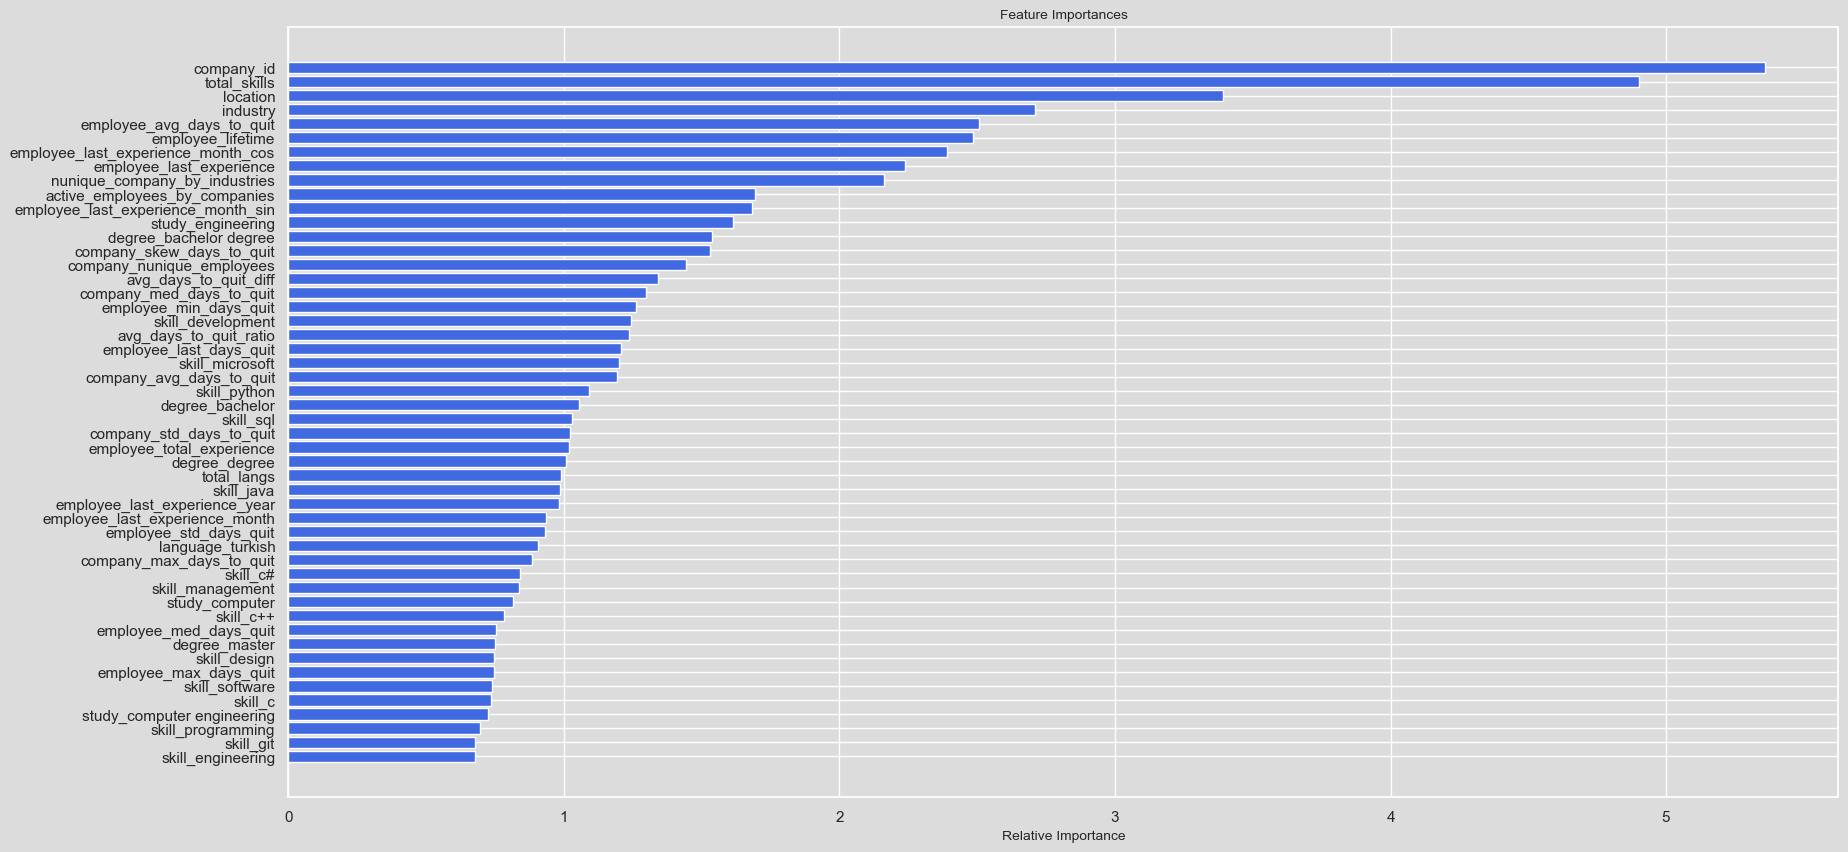

fold accuracy: 0.7873712798461017
-----------------------------------| Fold 2 |-----------------------------------
train: (44182, 288)
val: (8837, 288)
0:	learn: 0.6382011	test: 0.6461469	best: 0.6461469 (0)	total: 283ms	remaining: 18m 52s
250:	learn: 0.8125707	test: 0.7545547	best: 0.7548942 (249)	total: 52.8s	remaining: 13m 9s
500:	learn: 0.8603277	test: 0.7682471	best: 0.7682471 (500)	total: 1m 45s	remaining: 12m 20s
750:	learn: 0.9080168	test: 0.7774131	best: 0.7774131 (750)	total: 2m 40s	remaining: 11m 34s
1000:	learn: 0.9348377	test: 0.7855607	best: 0.7855607 (993)	total: 3m 34s	remaining: 10m 42s
1250:	learn: 0.9543027	test: 0.7888424	best: 0.7889555 (1249)	total: 4m 28s	remaining: 9m 51s
1500:	learn: 0.9673623	test: 0.7922372	best: 0.7928030 (1385)	total: 5m 23s	remaining: 8m 58s
1750:	learn: 0.9753520	test: 0.7947267	best: 0.7955188 (1678)	total: 6m 17s	remaining: 8m 5s
2000:	learn: 0.9817120	test: 0.7947267	best: 0.7961978 (1960)	total: 7m 11s	remaining: 7m 10s
2250:	learn: 0

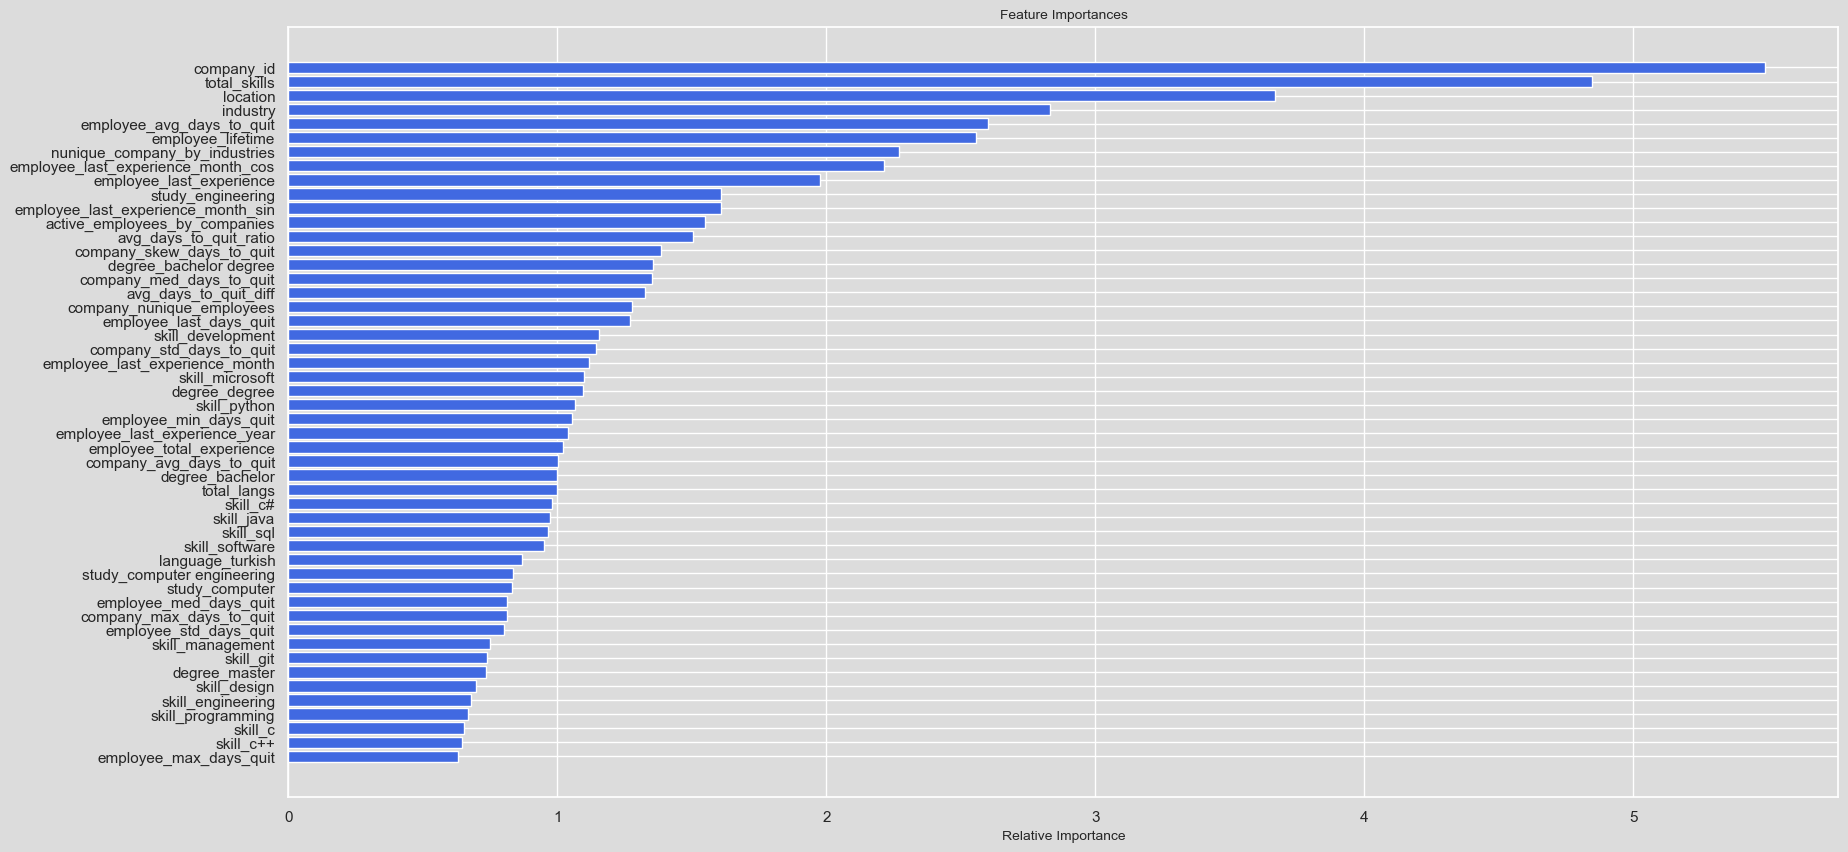

fold accuracy: 0.7963109652597036
-----------------------------------| Fold 3 |-----------------------------------
train: (44182, 288)
val: (8837, 288)
0:	learn: 0.6408492	test: 0.6335861	best: 0.6335861 (0)	total: 308ms	remaining: 20m 32s
250:	learn: 0.8143588	test: 0.7374675	best: 0.7379201 (246)	total: 53.4s	remaining: 13m 18s
500:	learn: 0.8646734	test: 0.7525178	best: 0.7525178 (500)	total: 1m 46s	remaining: 12m 24s
750:	learn: 0.9075415	test: 0.7616838	best: 0.7624760 (736)	total: 2m 39s	remaining: 11m 31s
1000:	learn: 0.9370332	test: 0.7693787	best: 0.7701709 (922)	total: 3m 33s	remaining: 10m 40s
1250:	learn: 0.9573129	test: 0.7726604	best: 0.7734525 (1221)	total: 4m 27s	remaining: 9m 47s
1500:	learn: 0.9701915	test: 0.7753763	best: 0.7762815 (1474)	total: 5m 21s	remaining: 8m 54s
1750:	learn: 0.9775927	test: 0.7767342	best: 0.7769605 (1602)	total: 6m 15s	remaining: 8m 2s
2000:	learn: 0.9832285	test: 0.7796764	best: 0.7799027 (1998)	total: 7m 10s	remaining: 7m 10s
2250:	learn: 

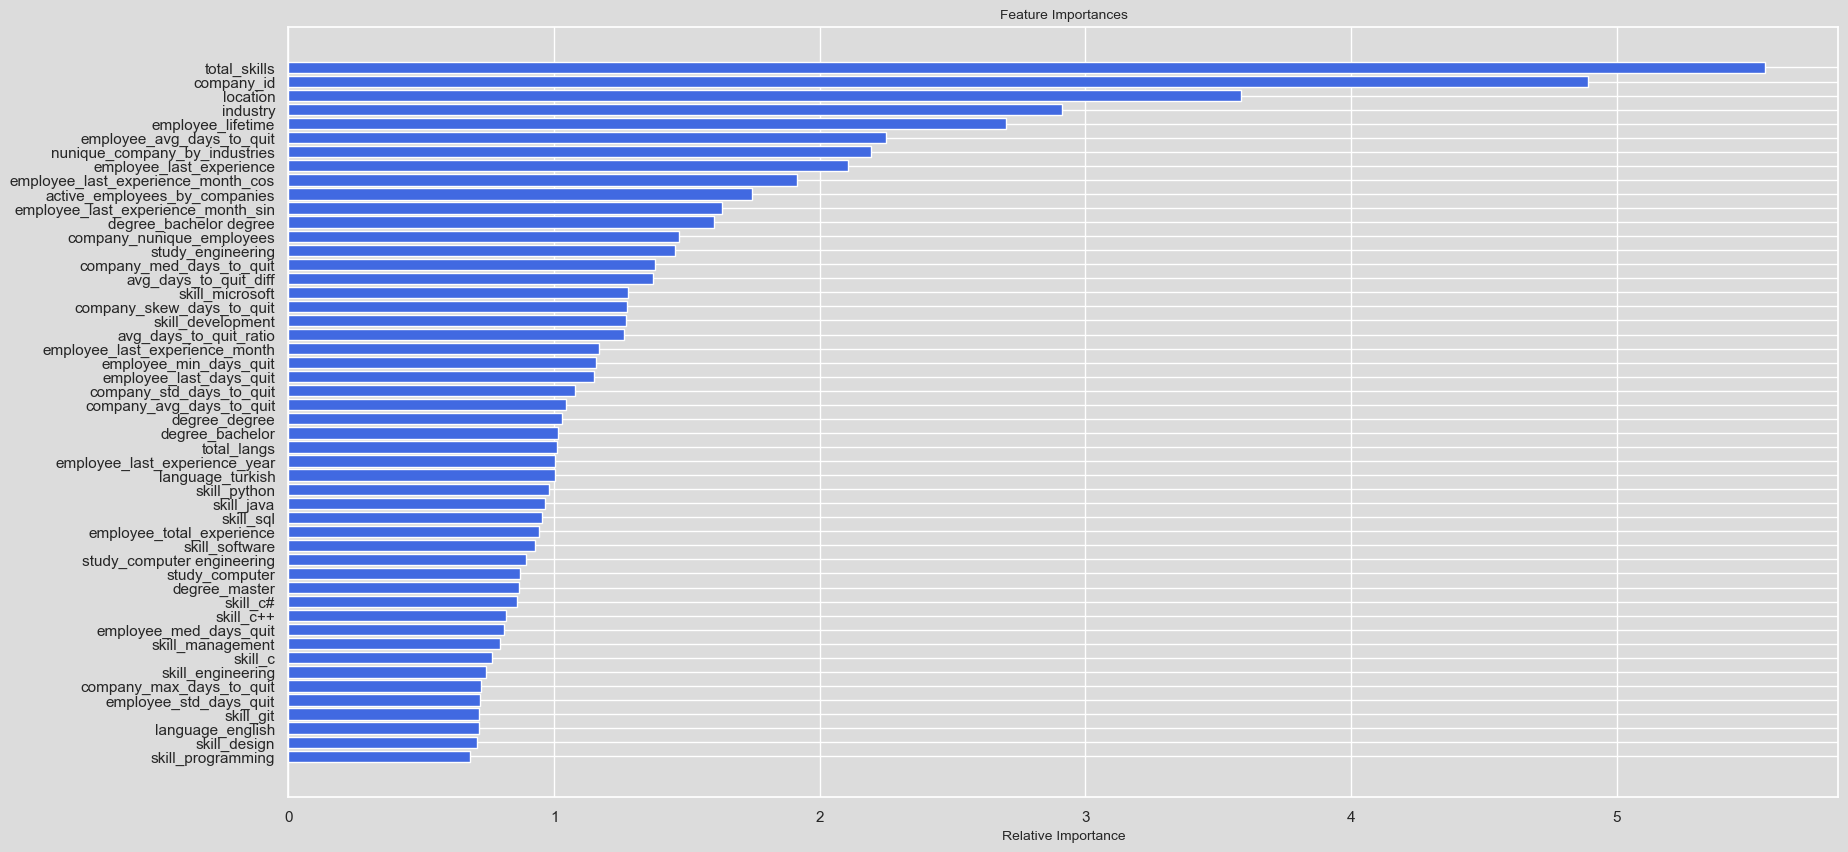

fold accuracy: 0.7823922145524499
-----------------------------------| Fold 4 |-----------------------------------
train: (44183, 288)
val: (8836, 288)
0:	learn: 0.6601408	test: 0.6410140	best: 0.6410140 (0)	total: 342ms	remaining: 22m 47s
250:	learn: 0.8174411	test: 0.7427569	best: 0.7430964 (247)	total: 55.2s	remaining: 13m 44s
500:	learn: 0.8656497	test: 0.7566772	best: 0.7567904 (496)	total: 1m 48s	remaining: 12m 38s
750:	learn: 0.9034697	test: 0.7681077	best: 0.7689000 (741)	total: 2m 43s	remaining: 11m 46s
1000:	learn: 0.9329380	test: 0.7772748	best: 0.7779538 (985)	total: 3m 37s	remaining: 10m 50s
1250:	learn: 0.9516556	test: 0.7822544	best: 0.7827071 (1177)	total: 4m 31s	remaining: 9m 55s
1500:	learn: 0.9650092	test: 0.7844047	best: 0.7855364 (1461)	total: 5m 25s	remaining: 9m 2s
1750:	learn: 0.9729760	test: 0.7865550	best: 0.7879131 (1542)	total: 6m 20s	remaining: 8m 9s
2000:	learn: 0.9796981	test: 0.7877999	best: 0.7883658 (1835)	total: 7m 14s	remaining: 7m 14s
2250:	learn: 0

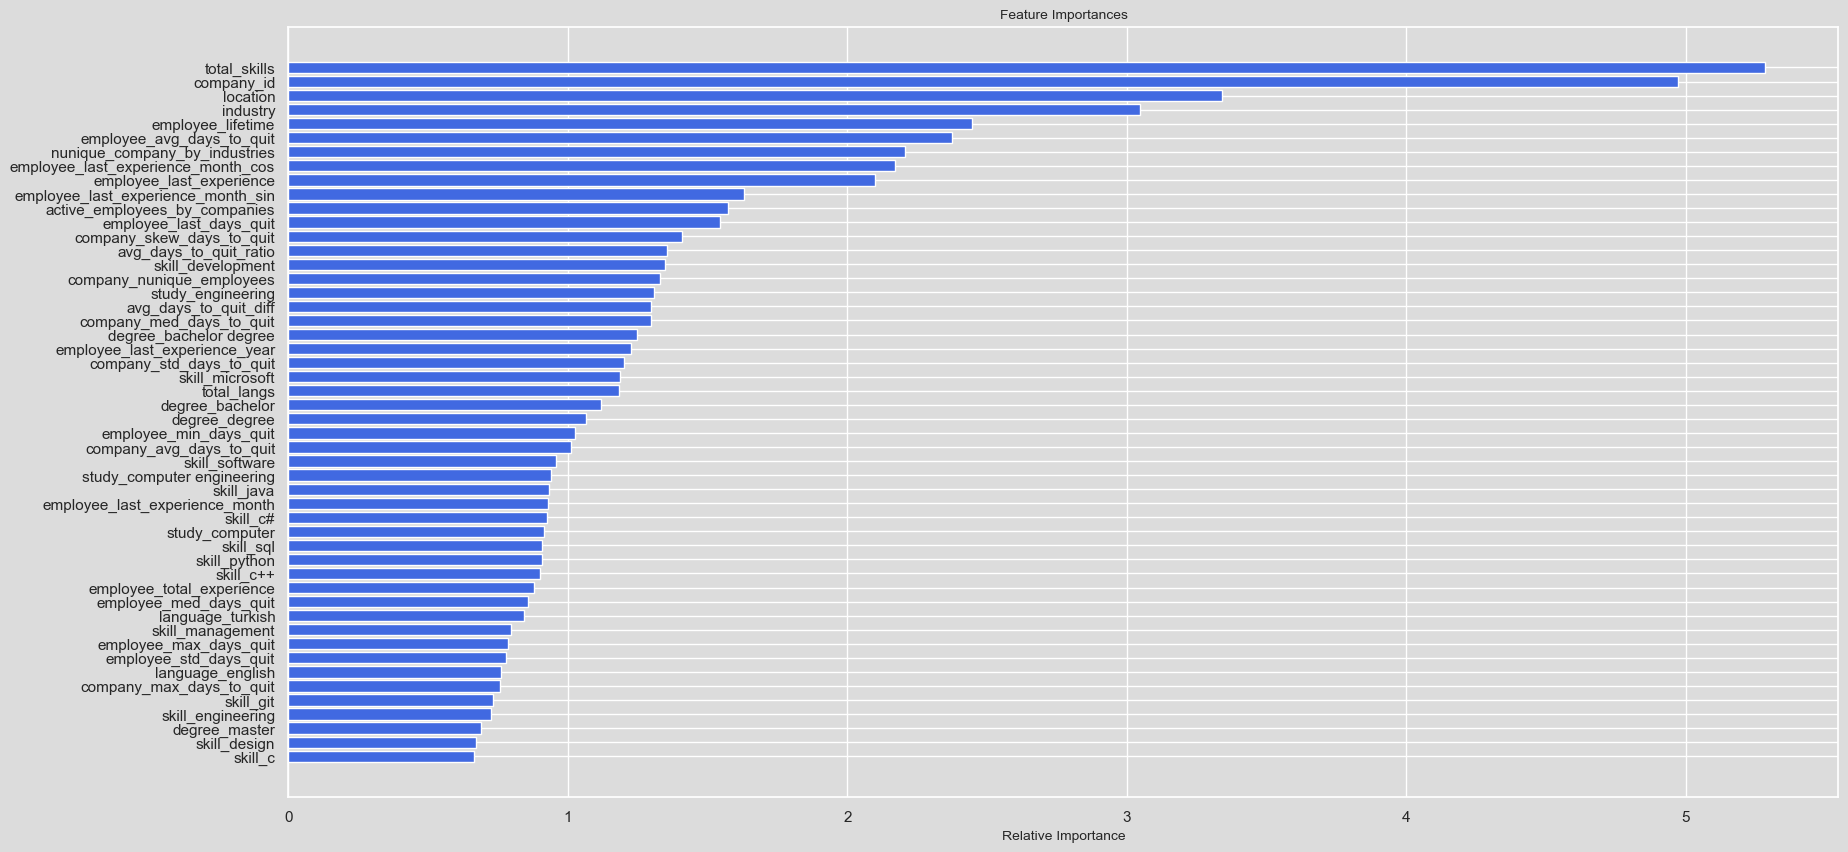

fold accuracy: 0.7901765504753282
-----------------------------------| Fold 5 |-----------------------------------
train: (44183, 288)
val: (8836, 288)
0:	learn: 0.6559536	test: 0.6368266	best: 0.6368266 (0)	total: 333ms	remaining: 22m 10s
250:	learn: 0.8155173	test: 0.7469443	best: 0.7469443 (243)	total: 53.9s	remaining: 13m 25s
500:	learn: 0.8675735	test: 0.7623359	best: 0.7623359 (493)	total: 1m 49s	remaining: 12m 43s
750:	learn: 0.9094448	test: 0.7718425	best: 0.7719556 (749)	total: 2m 46s	remaining: 11m 58s
1000:	learn: 0.9362198	test: 0.7770484	best: 0.7770484 (1000)	total: 3m 41s	remaining: 11m 2s
1250:	learn: 0.9545074	test: 0.7787460	best: 0.7793119 (1185)	total: 4m 36s	remaining: 10m 6s
1500:	learn: 0.9662314	test: 0.7814622	best: 0.7816885 (1473)	total: 5m 29s	remaining: 9m 9s
1750:	learn: 0.9748546	test: 0.7813490	best: 0.7827071 (1689)	total: 6m 23s	remaining: 8m 12s
2000:	learn: 0.9811919	test: 0.7829335	best: 0.7834993 (1906)	total: 7m 16s	remaining: 7m 16s
2250:	learn: 

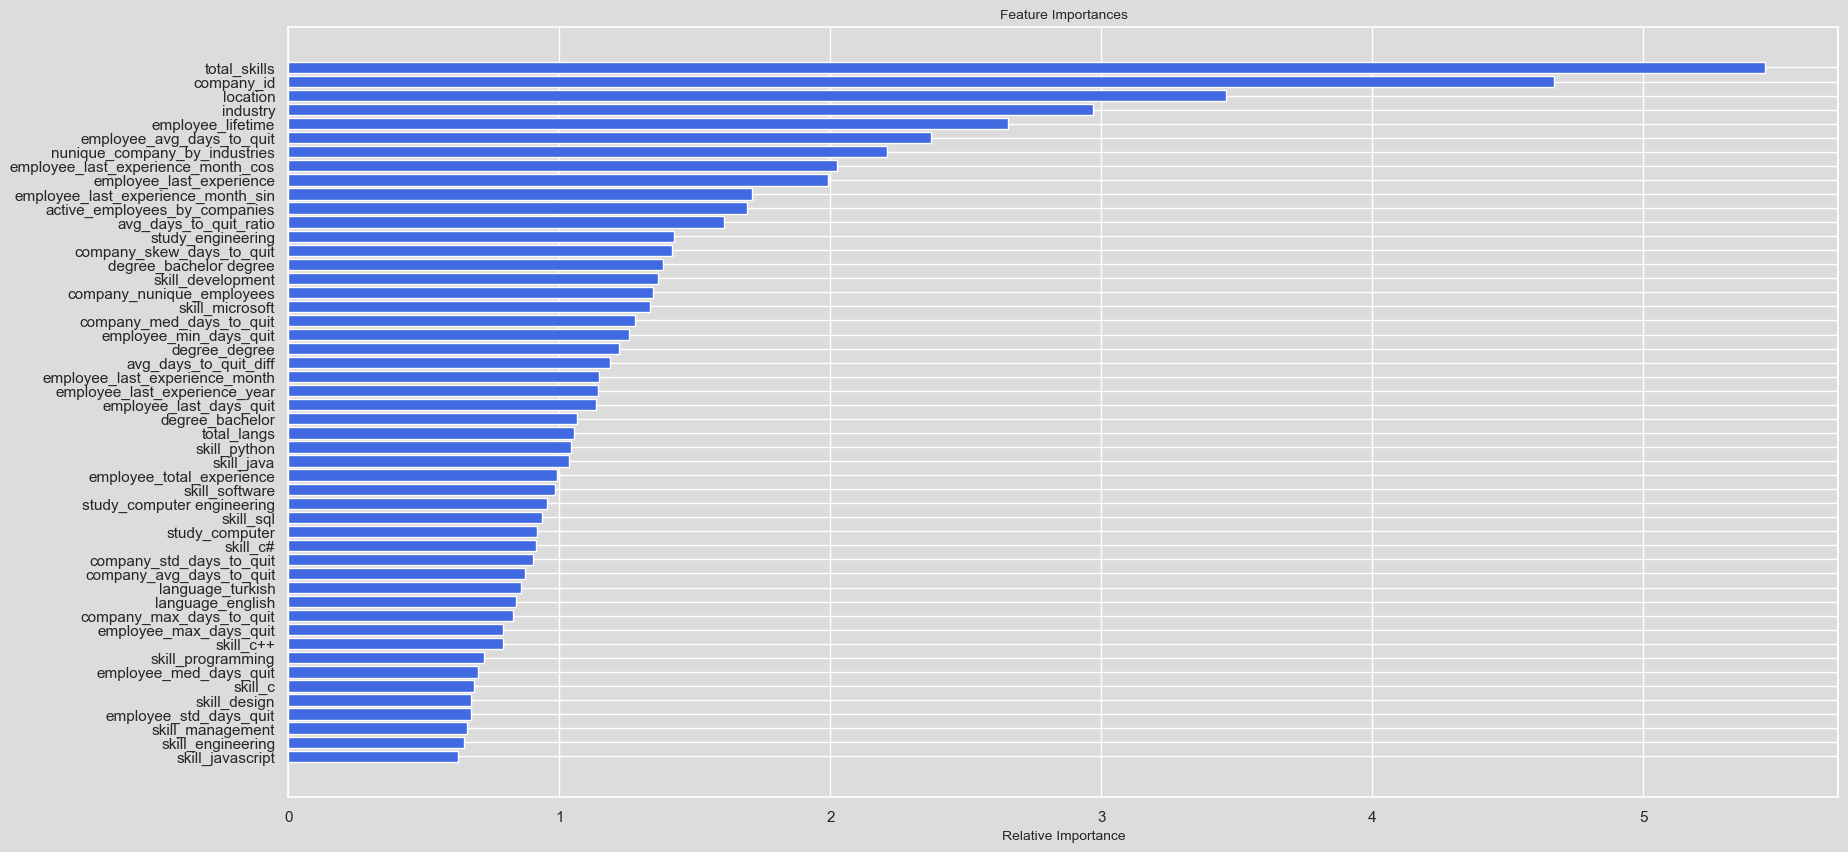

fold accuracy: 0.7870076957899502
-----------------------------------| Fold 6 |-----------------------------------
train: (44183, 288)
val: (8836, 288)
0:	learn: 0.6594165	test: 0.6481440	best: 0.6481440 (0)	total: 344ms	remaining: 22m 56s
250:	learn: 0.8160378	test: 0.7429833	best: 0.7434359 (248)	total: 54.4s	remaining: 13m 32s
500:	learn: 0.8653102	test: 0.7564509	best: 0.7564509 (493)	total: 1m 49s	remaining: 12m 44s
750:	learn: 0.9090374	test: 0.7673155	best: 0.7674287 (741)	total: 2m 43s	remaining: 11m 47s
1000:	learn: 0.9378947	test: 0.7750113	best: 0.7756904 (954)	total: 3m 38s	remaining: 10m 55s
1250:	learn: 0.9570197	test: 0.7787460	best: 0.7793119 (1214)	total: 4m 33s	remaining: 10m
1500:	learn: 0.9686531	test: 0.7818017	best: 0.7818017 (1488)	total: 5m 25s	remaining: 9m 2s
1750:	learn: 0.9770274	test: 0.7832730	best: 0.7839520 (1637)	total: 6m 19s	remaining: 8m 6s
2000:	learn: 0.9825725	test: 0.7838388	best: 0.7853101 (1939)	total: 7m 13s	remaining: 7m 13s
2250:	learn: 0.98

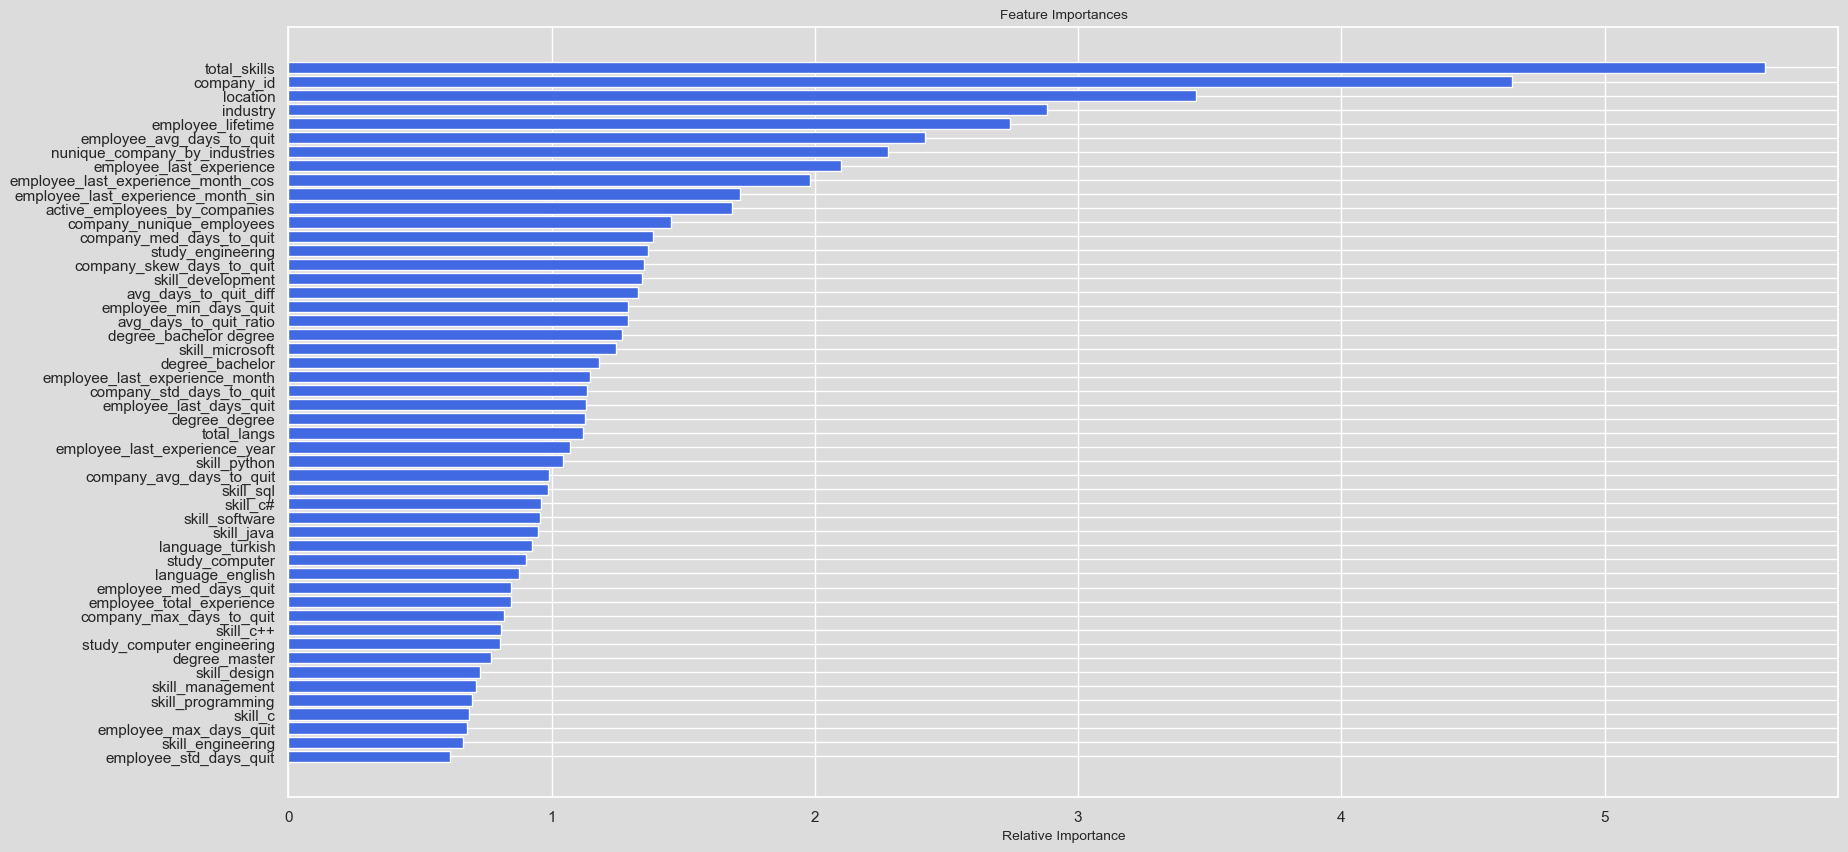

fold accuracy: 0.7889316432775011
accuracy: 0.7886983911427978
folds avg accuracy: 0.7886983915335057


In [7]:
cat1_scores = get_model_scores(cat1, kf, train_set, test_set, 'moved_after_2019', config.n_folds, True) #0.7886983911427978

-----------------------------------| Fold 1 |-----------------------------------
train: (44182, 288)
val: (8837, 288)
[0]	validation_0-logloss:0.69081
[250]	validation_0-logloss:0.54356
[500]	validation_0-logloss:0.51390
[750]	validation_0-logloss:0.49359
[1000]	validation_0-logloss:0.47926
[1250]	validation_0-logloss:0.46765
[1500]	validation_0-logloss:0.45924
[1750]	validation_0-logloss:0.45382
[2000]	validation_0-logloss:0.45044
[2250]	validation_0-logloss:0.44889
[2500]	validation_0-logloss:0.44821
[2750]	validation_0-logloss:0.44824
[3000]	validation_0-logloss:0.44917
[3102]	validation_0-logloss:0.44958


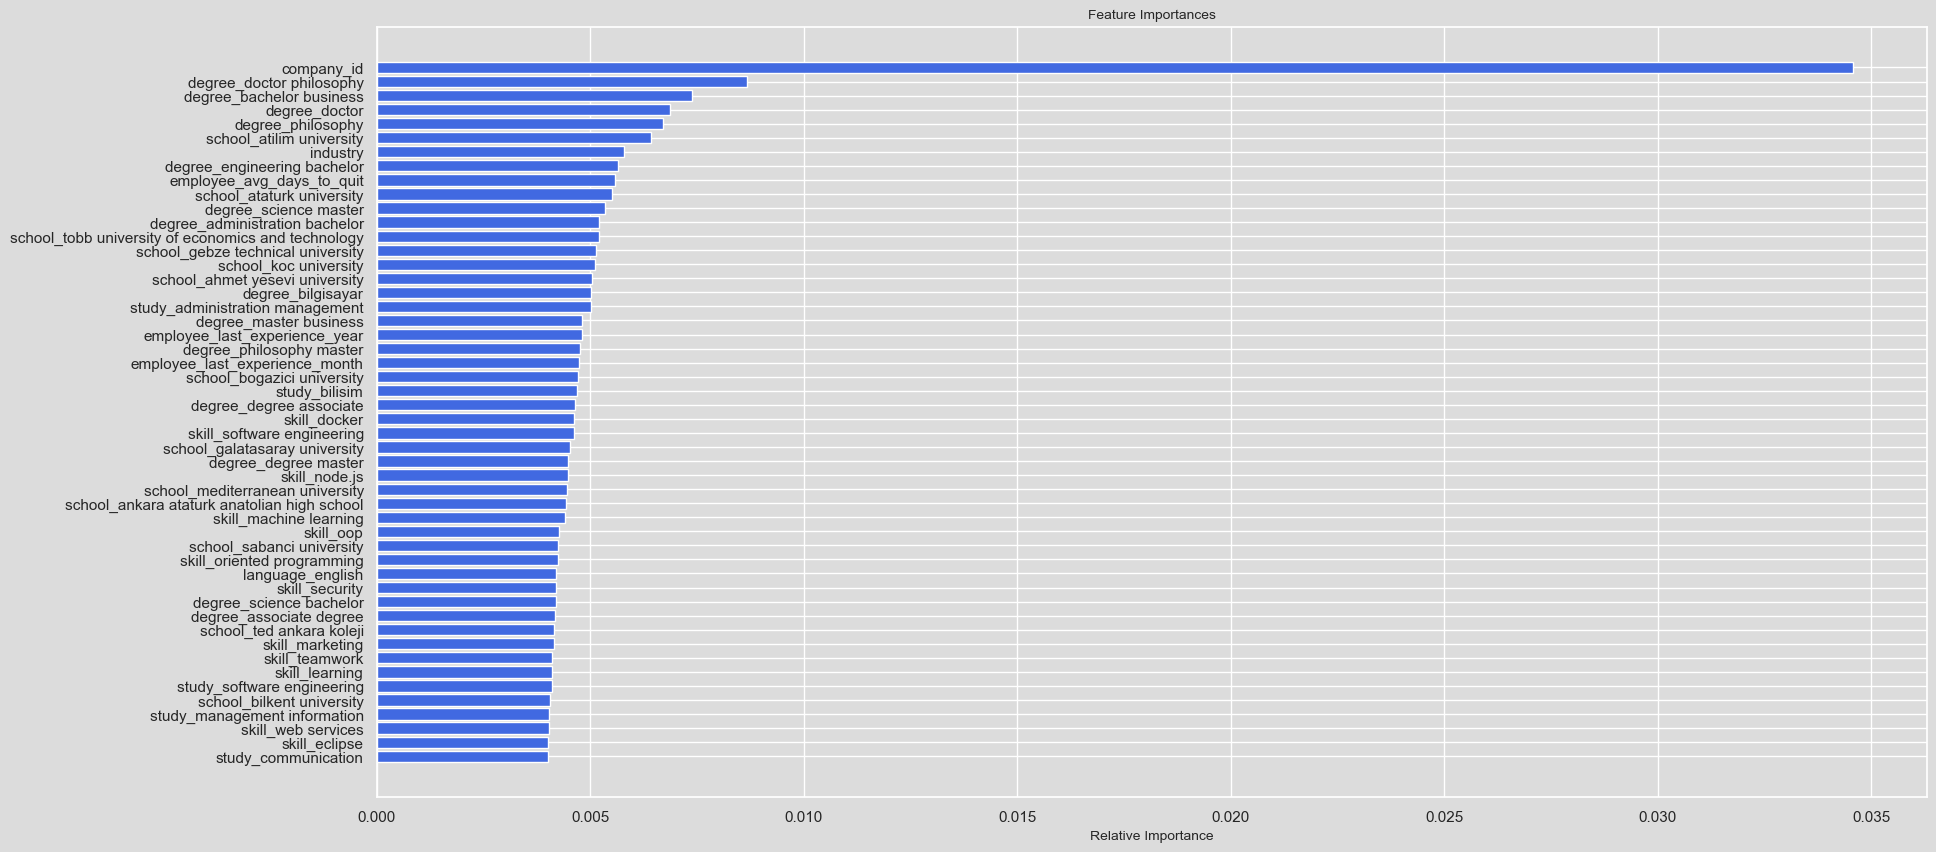

fold accuracy: 0.7823922145524499
-----------------------------------| Fold 2 |-----------------------------------
train: (44182, 288)
val: (8837, 288)
[0]	validation_0-logloss:0.69066
[250]	validation_0-logloss:0.52709
[500]	validation_0-logloss:0.49462
[750]	validation_0-logloss:0.47309
[1000]	validation_0-logloss:0.45683
[1250]	validation_0-logloss:0.44486
[1500]	validation_0-logloss:0.43613
[1750]	validation_0-logloss:0.43004
[2000]	validation_0-logloss:0.42595
[2250]	validation_0-logloss:0.42383
[2500]	validation_0-logloss:0.42287
[2750]	validation_0-logloss:0.42319
[3000]	validation_0-logloss:0.42373
[3043]	validation_0-logloss:0.42389


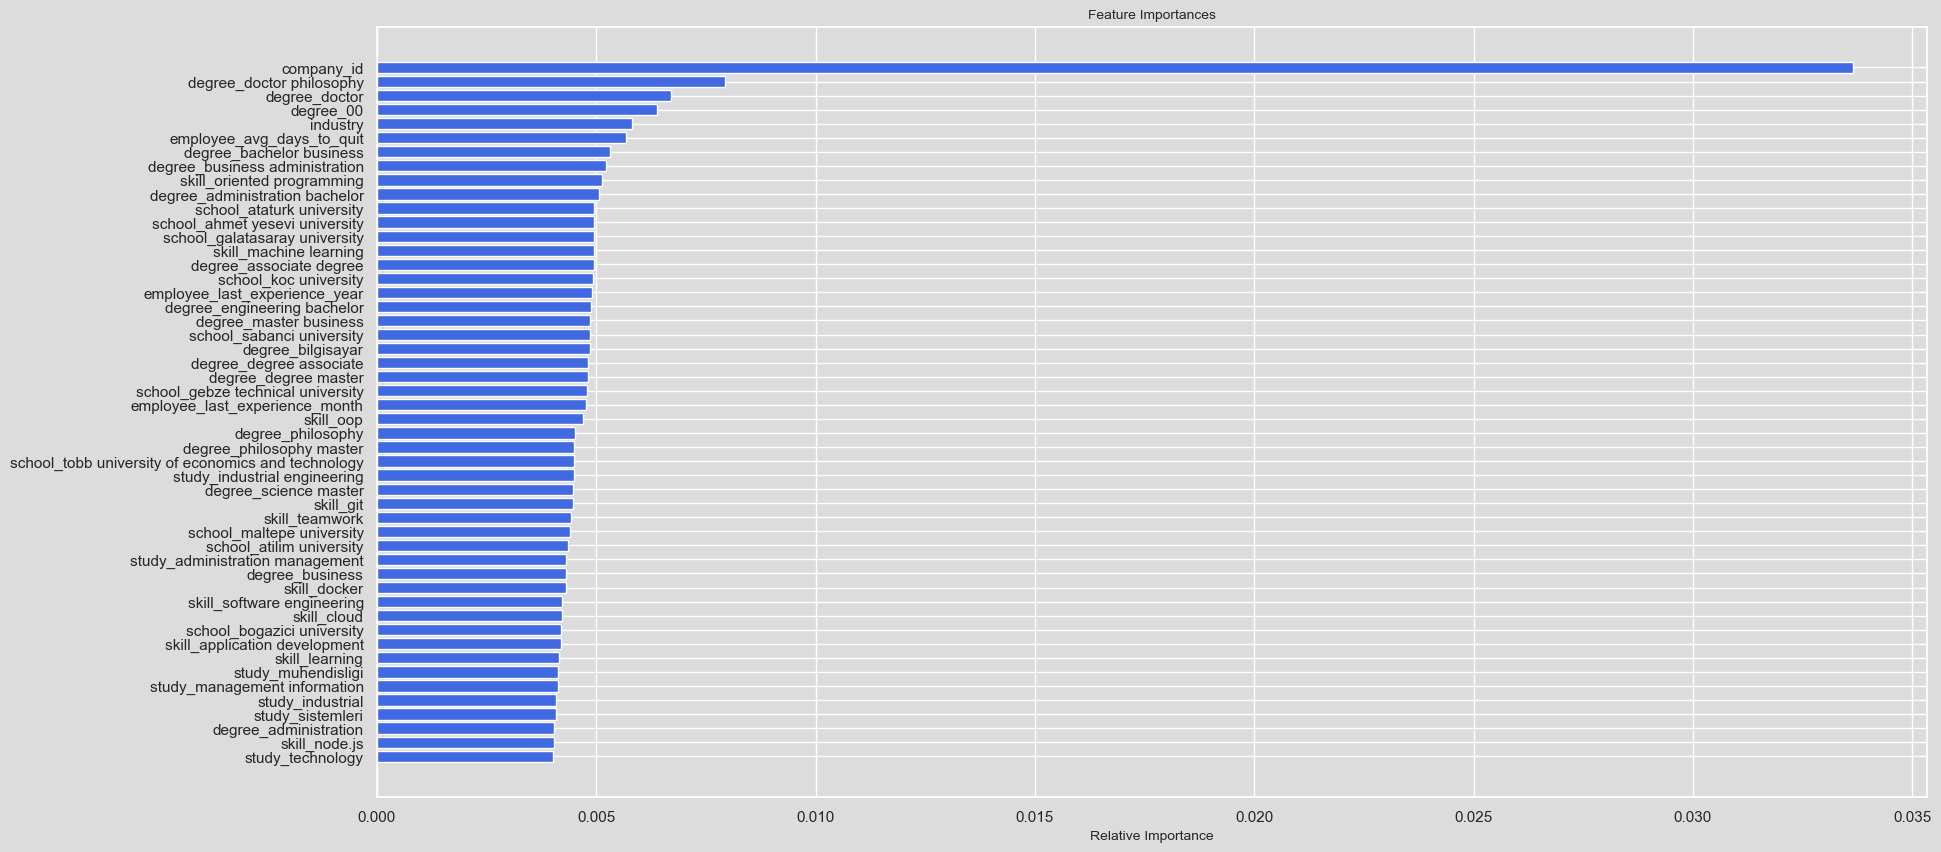

fold accuracy: 0.7956320018105691
-----------------------------------| Fold 3 |-----------------------------------
train: (44182, 288)
val: (8837, 288)
[0]	validation_0-logloss:0.69066
[250]	validation_0-logloss:0.53950
[500]	validation_0-logloss:0.50958
[750]	validation_0-logloss:0.48974
[1000]	validation_0-logloss:0.47525
[1250]	validation_0-logloss:0.46436
[1500]	validation_0-logloss:0.45699
[1750]	validation_0-logloss:0.45189
[2000]	validation_0-logloss:0.44933
[2250]	validation_0-logloss:0.44834
[2500]	validation_0-logloss:0.44832
[2750]	validation_0-logloss:0.44931
[2912]	validation_0-logloss:0.45016


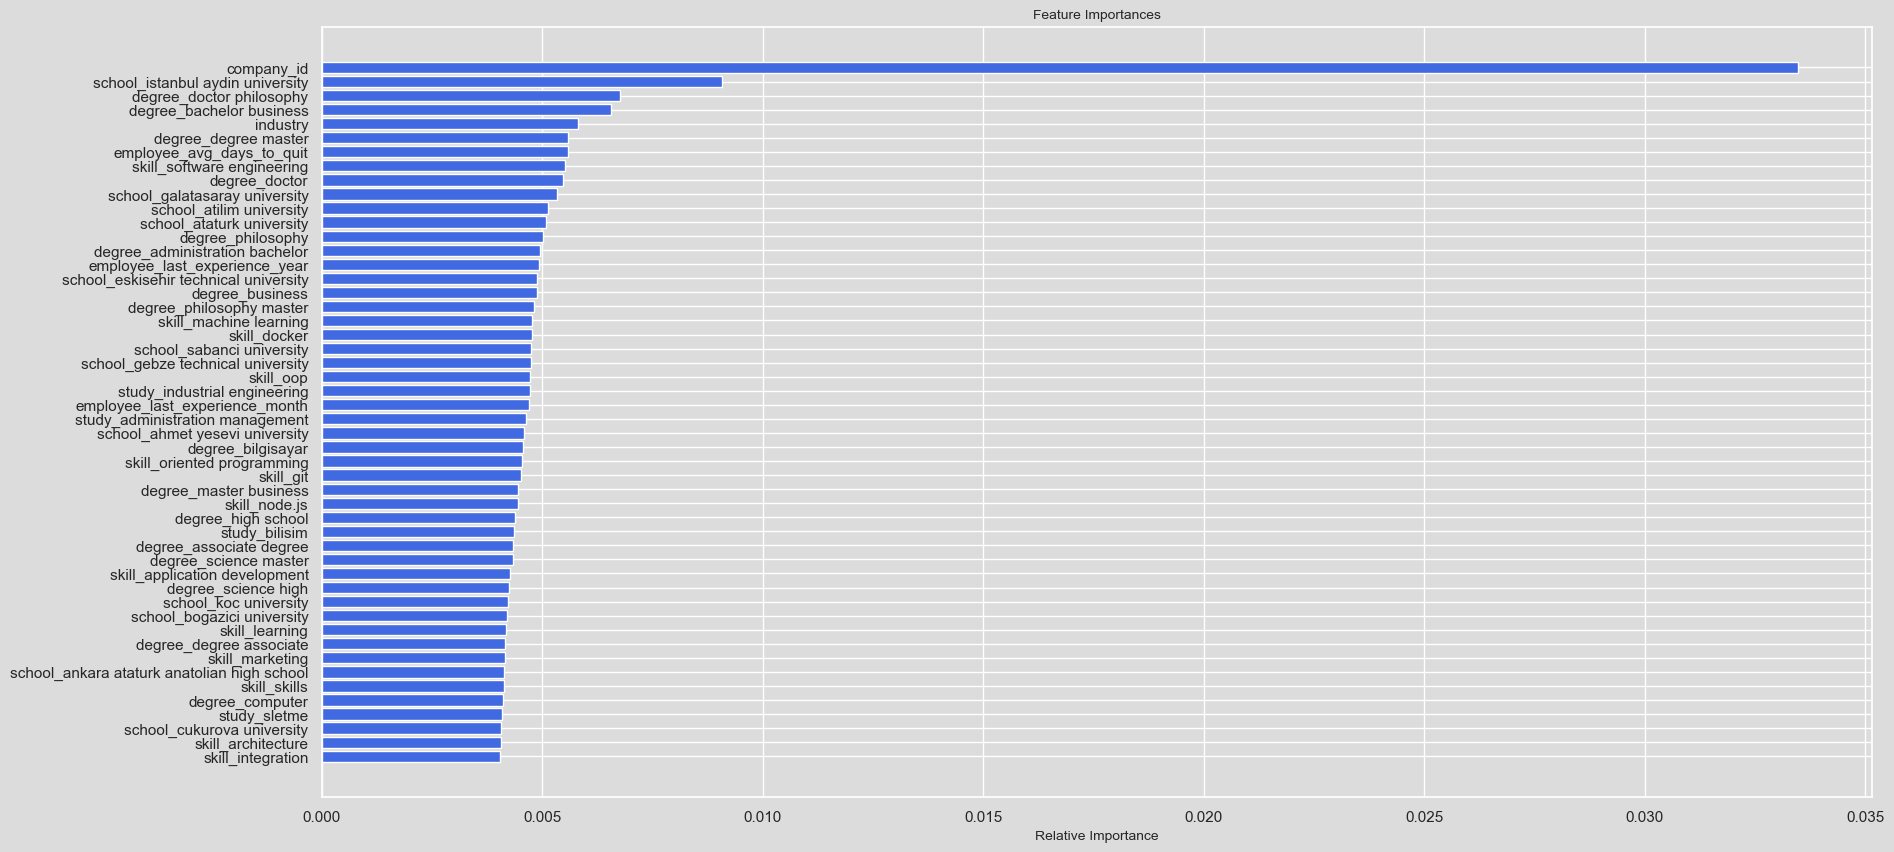

fold accuracy: 0.7823922145524499
-----------------------------------| Fold 4 |-----------------------------------
train: (44183, 288)
val: (8836, 288)
[0]	validation_0-logloss:0.69069
[250]	validation_0-logloss:0.54271
[500]	validation_0-logloss:0.51498
[750]	validation_0-logloss:0.49449
[1000]	validation_0-logloss:0.47871
[1250]	validation_0-logloss:0.46682
[1500]	validation_0-logloss:0.45782
[1750]	validation_0-logloss:0.45200
[2000]	validation_0-logloss:0.44837
[2250]	validation_0-logloss:0.44640
[2500]	validation_0-logloss:0.44537
[2750]	validation_0-logloss:0.44531
[3000]	validation_0-logloss:0.44602
[3074]	validation_0-logloss:0.44616


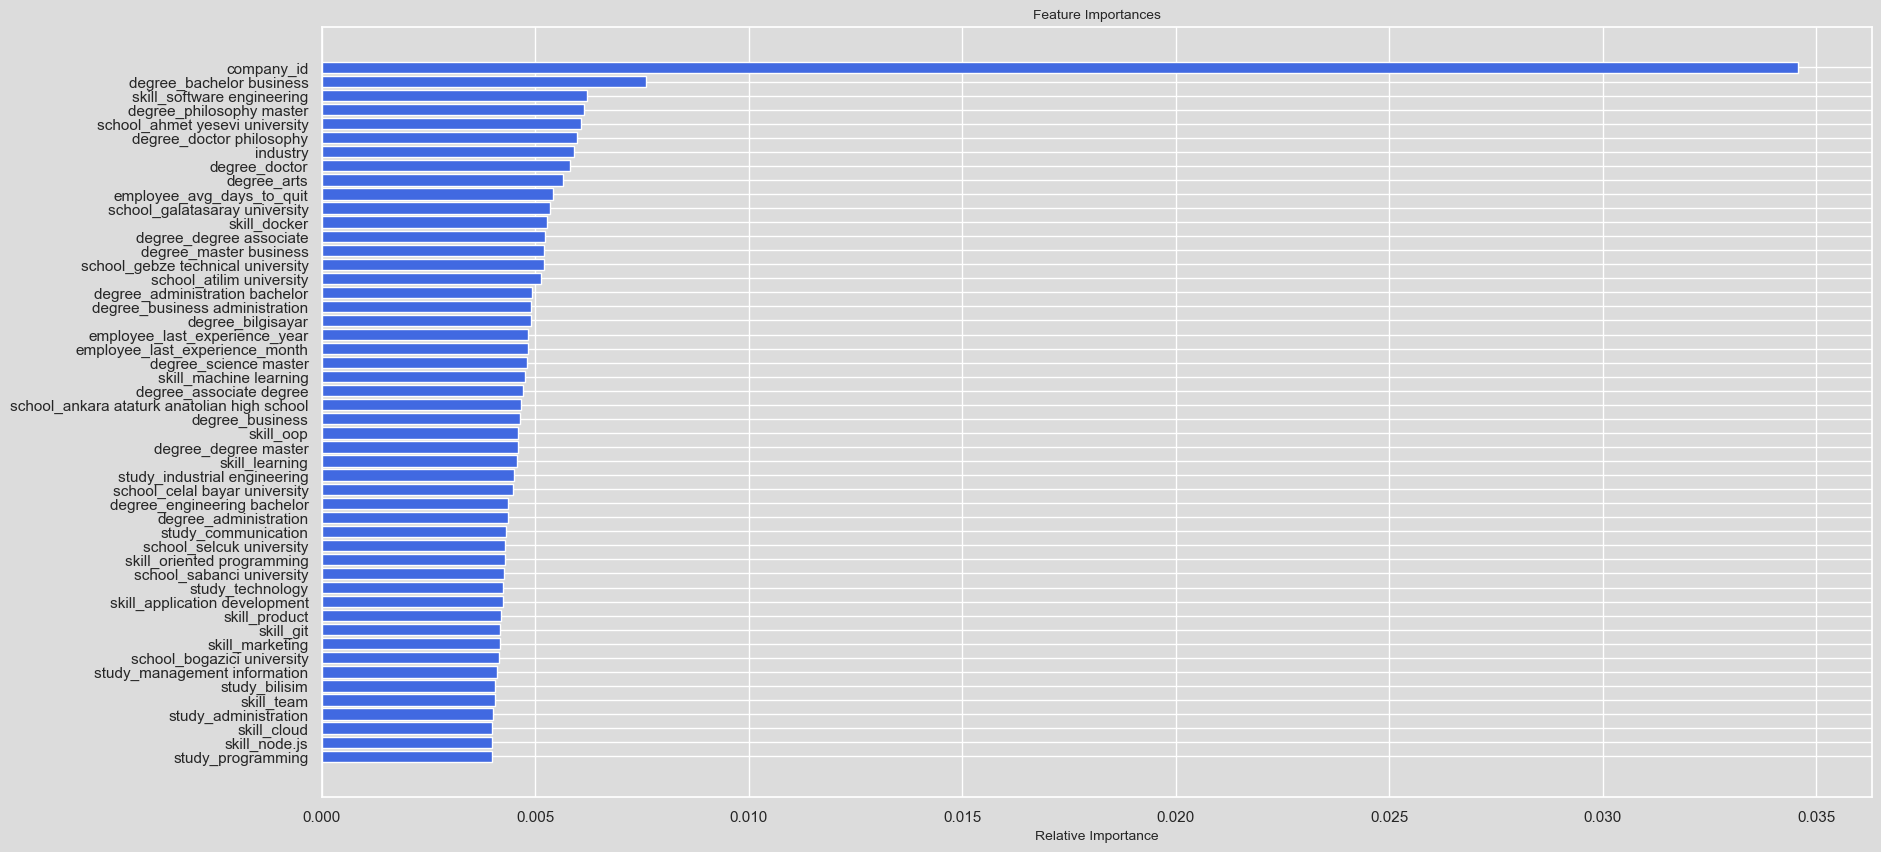

fold accuracy: 0.7853100950656405
-----------------------------------| Fold 5 |-----------------------------------
train: (44183, 288)
val: (8836, 288)
[0]	validation_0-logloss:0.69061
[250]	validation_0-logloss:0.53904
[500]	validation_0-logloss:0.50980
[750]	validation_0-logloss:0.49041
[1000]	validation_0-logloss:0.47520
[1250]	validation_0-logloss:0.46386
[1500]	validation_0-logloss:0.45670
[1750]	validation_0-logloss:0.45189
[2000]	validation_0-logloss:0.44891
[2250]	validation_0-logloss:0.44808
[2500]	validation_0-logloss:0.44812
[2750]	validation_0-logloss:0.44876
[2918]	validation_0-logloss:0.44971


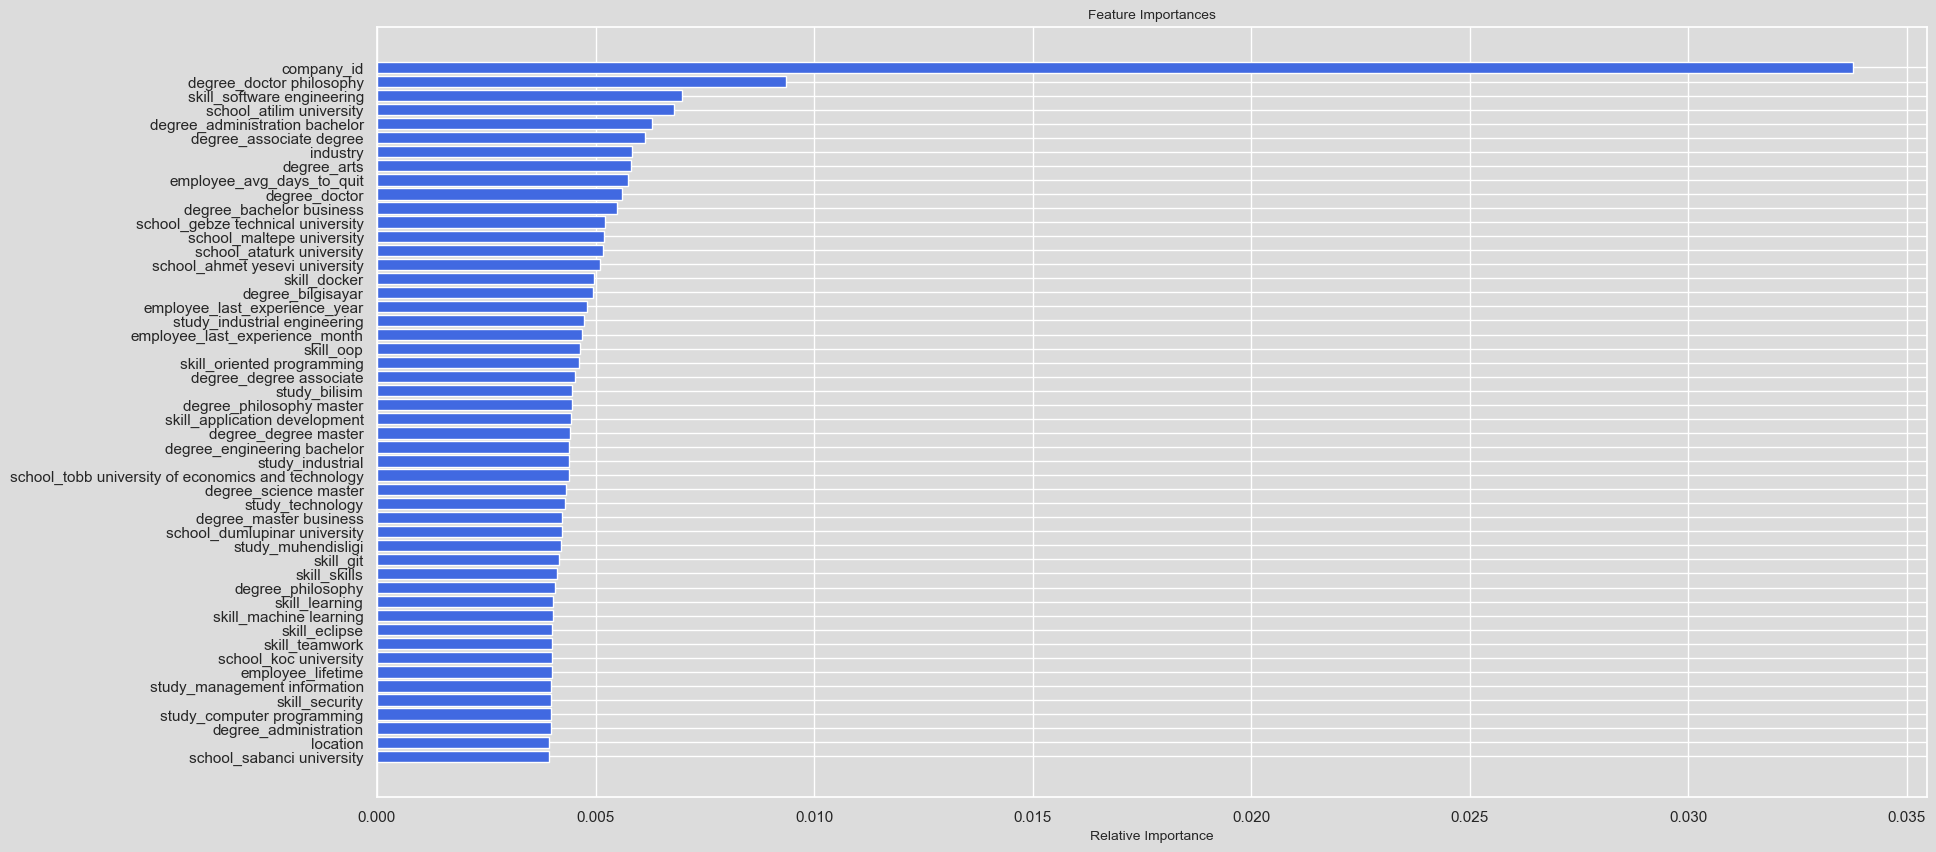

fold accuracy: 0.7853100950656405
-----------------------------------| Fold 6 |-----------------------------------
train: (44183, 288)
val: (8836, 288)
[0]	validation_0-logloss:0.69070
[250]	validation_0-logloss:0.53520
[500]	validation_0-logloss:0.50428
[750]	validation_0-logloss:0.48362
[1000]	validation_0-logloss:0.46879
[1250]	validation_0-logloss:0.45763
[1500]	validation_0-logloss:0.44973
[1750]	validation_0-logloss:0.44452
[2000]	validation_0-logloss:0.44151
[2250]	validation_0-logloss:0.44023
[2500]	validation_0-logloss:0.43954
[2750]	validation_0-logloss:0.43991
[2923]	validation_0-logloss:0.44077


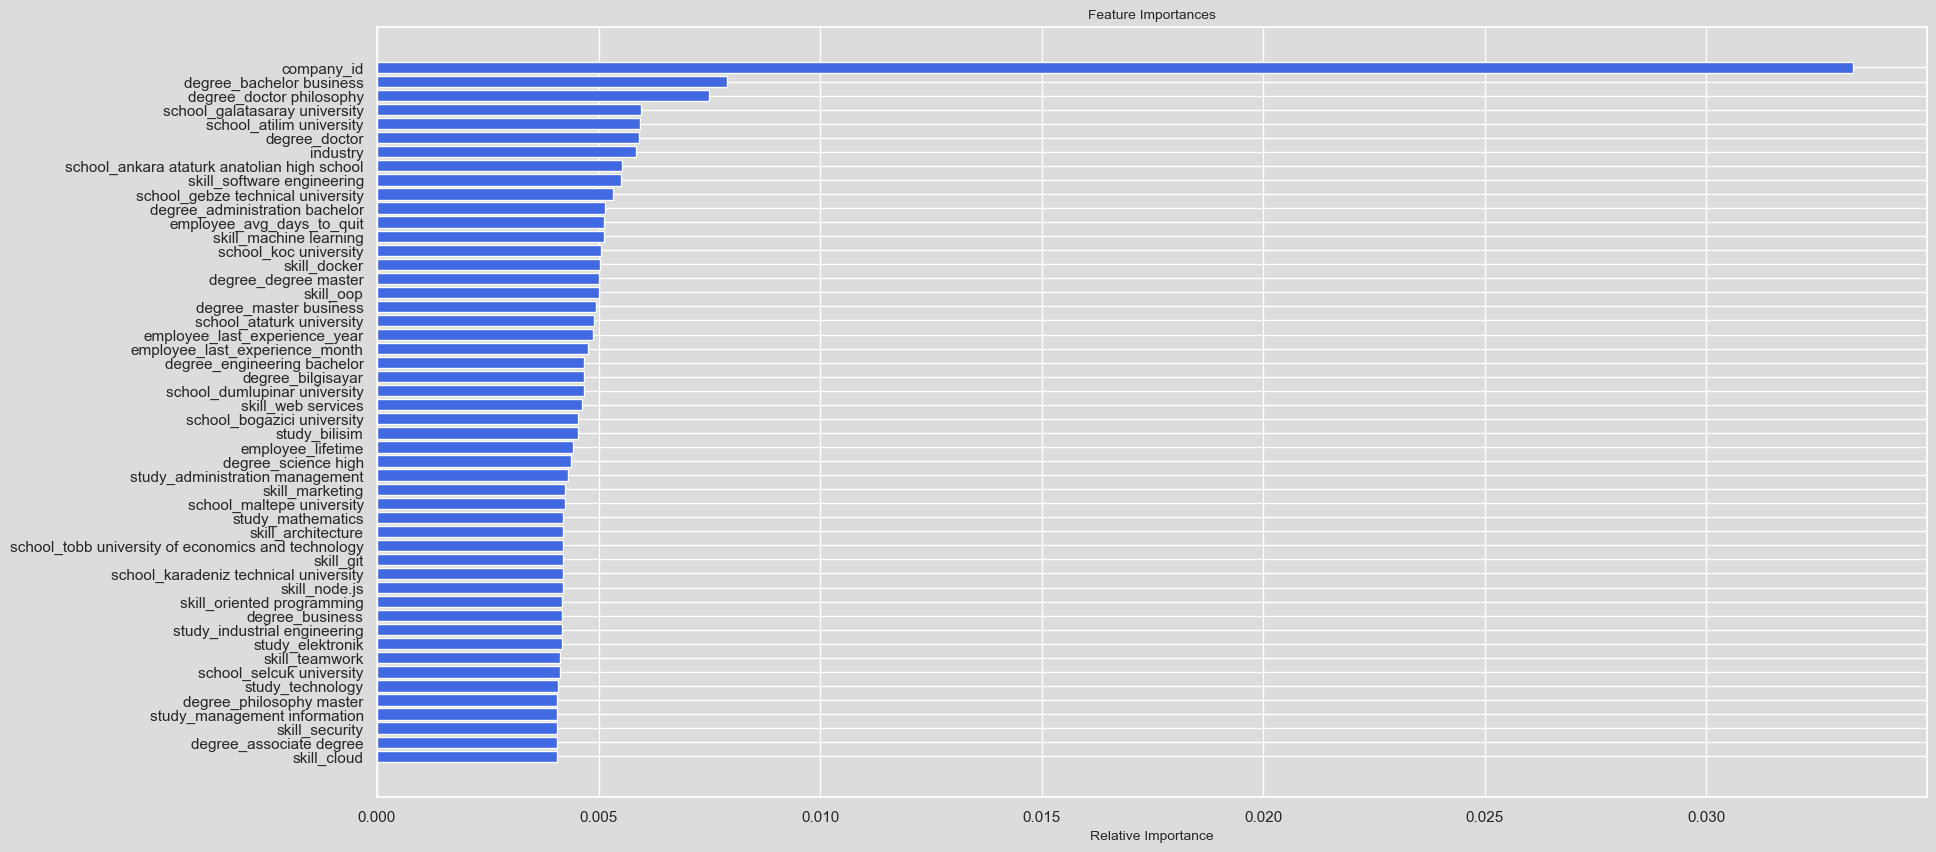

fold accuracy: 0.7910819375282934
accuracy: 0.7870197476376394
folds avg accuracy: 0.7870197597625074


In [8]:
xgb1_scores = get_model_scores(xgb1, kf, train_set, test_set, 'moved_after_2019', config.n_folds, True) #0.7870197476376394

In [10]:
#cat2_scores = get_model_scores(cat2, kf, train_set, test_set, 'moved_after_2019', config.n_folds, True) #0.7847375469171429

In [35]:
sub[target] = np.where((cat1_scores[:, 1] * 0.7) + (xgb1_scores[:, 1] * 0.3)  >= 0.499, 1, 0)
#sub[target] = np.where(cat1_scores[:, 1] >= 0.499, 1, 0)
print(sub[target].value_counts())
sub.head(10)

0    9066
1    4189
Name: moved_after_2019, dtype: int64


user_id  moved_after_2019
0    17449                 0
1    33967                 0
2     2110                 0
3    55082                 0
4    37165                 0
5    42841                 1
6     8407                 0
7    17053                 0
8    24437                 1
9    44394                 0

In [36]:
sub.to_csv(f'../submissions/ensemble_cat_xgb_v20.csv', index = False)

In [22]:
ensoas = pd.read_csv('../submissions/ensemble_cat_xgb_v7.csv')

print(ensoas[target].value_counts())
ensoas.head()

0    9053
1    4202
Name: moved_after_2019, dtype: int64


user_id  moved_after_2019
0    17449                 0
1    33967                 1
2     2110                 0
3    55082                 0
4    37165                 0

In [13]:
ensoas = pd.read_csv('../submissions/ensemble_of_all_subs.csv')

print(ensoas[target].value_counts())
ensoas.head()

0    9026
1    4229
Name: moved_after_2019, dtype: int64


user_id  moved_after_2019
0    17449                 0
1    33967                 1
2     2110                 0
3    55082                 0
4    37165                 0

In [ ]:
## CatBoost Parameters
##params = {'one_hot_max_size': 179,
##          'depth': 12,
##          'boosting_type': 'Plain',
##          'bootstrap_type': 'MVS',
##          #'bagging_temperature': 0.2
##          }
#
#params = {'one_hot_max_size': 170,
#          'depth': 12,
#          #'learning_rate': 0.008,
#          'boosting_type': 'Plain',
#          'bootstrap_type': 'MVS'}
#
#params["iterations"] = 4000
#params['random_state'] = config.seed
#params['cat_features'] = cat_features
#params['eval_metric'] = 'Accuracy'
#params['allow_writing_files'] = False
#params['verbose'] = False
#
### XGB Parameters
##params = {'max_depth': 10,
##          'subsample': 0.8,
##          'eta': 0.02,
##          'reg_alpha': 2,
##          'reg_lambda': 24,
##          'learning_rate': 0.01}
##
###params['eval_metric'] = 'Accuracy'
##params['random_state'] = config.seed
##params['tree_method'] = 'hist'
##params['n_estimators'] = 5000
##params['enable_categorical'] = True
#
#kf = KFold(n_splits=config.n_folds, shuffle=True, random_state=config.seed)
##kf = KFold(n_splits=config.n_folds)

-----------------------------------| Fold 1 |-----------------------------------
train: (44182, 271)
val: (8837, 271)
Learning rate set to 0.044197
0:	learn: 0.6540673	test: 0.6352835	best: 0.6352835 (0)	total: 324ms	remaining: 21m 37s
200:	learn: 0.8556426	test: 0.7461808	best: 0.7461808 (199)	total: 45.9s	remaining: 14m 26s
400:	learn: 0.9204880	test: 0.7641734	best: 0.7643997 (384)	total: 1m 31s	remaining: 13m 36s
600:	learn: 0.9517677	test: 0.7710762	best: 0.7714156 (595)	total: 2m 15s	remaining: 12m 46s
800:	learn: 0.9695804	test: 0.7767342	best: 0.7778658 (729)	total: 3m	remaining: 11m 59s
1000:	learn: 0.9799240	test: 0.7794500	best: 0.7804685 (966)	total: 3m 44s	remaining: 11m 12s
1200:	learn: 0.9857182	test: 0.7792237	best: 0.7812606 (1073)	total: 4m 28s	remaining: 10m 26s
1400:	learn: 0.9895659	test: 0.7809211	best: 0.7812606 (1073)	total: 5m 13s	remaining: 9m 42s
Stopped by overfitting detector  (400 iterations wait)

bestTest = 0.7812606088
bestIteration = 1073

Shrink model

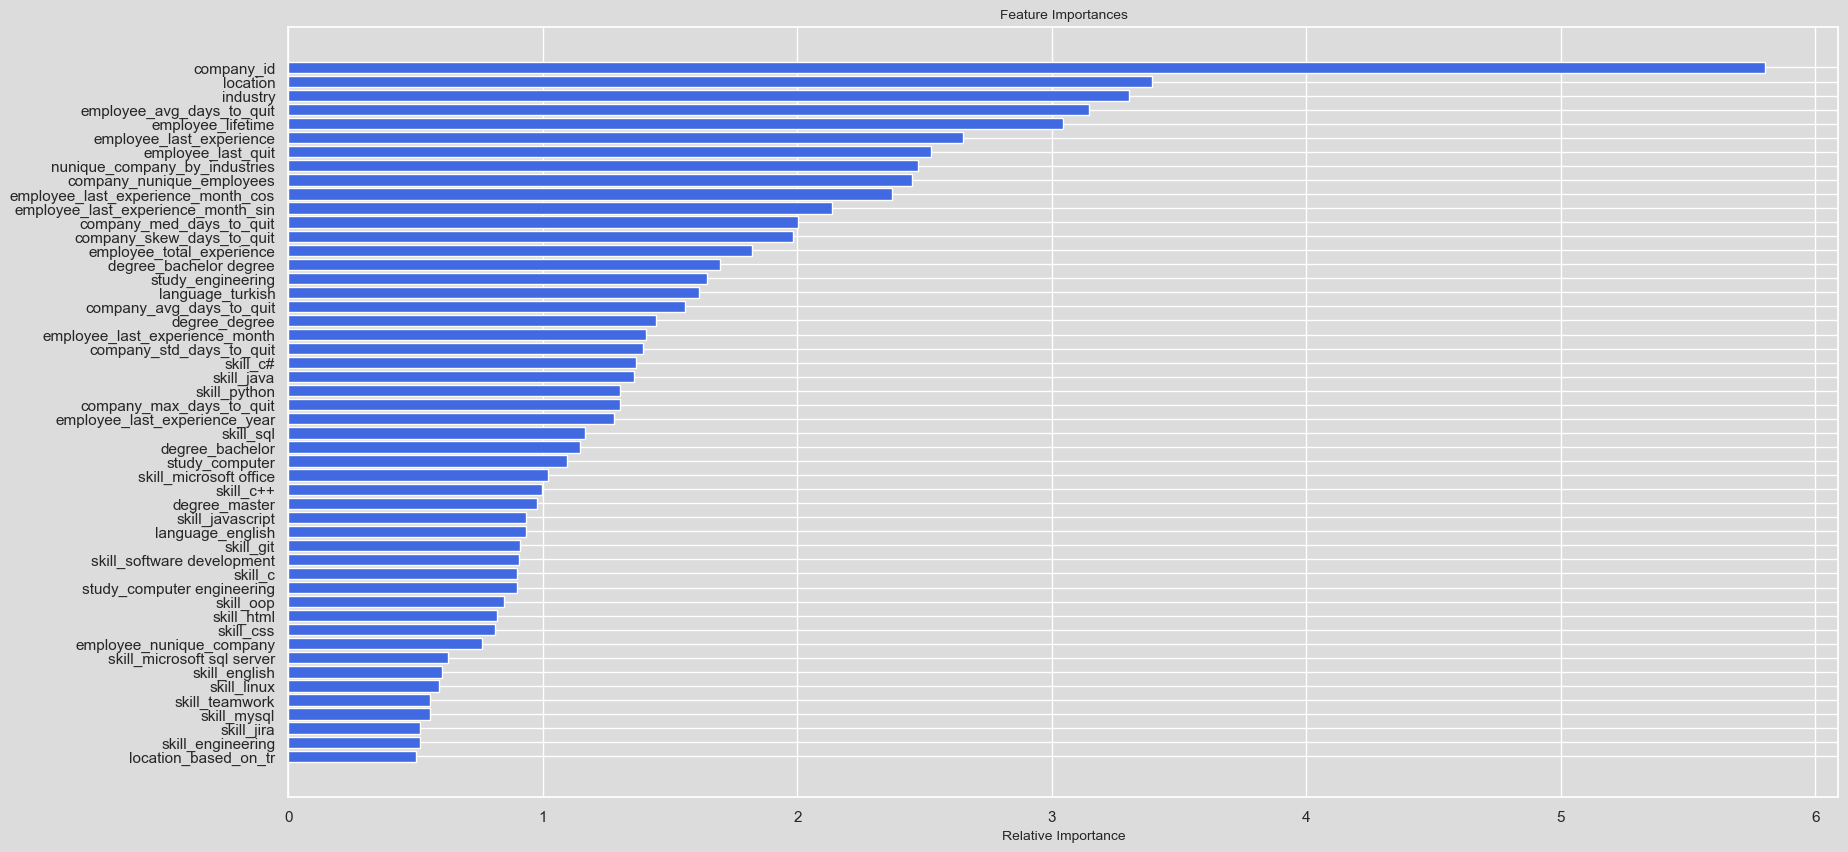

fold accuracy: 0.7812606088038927
-----------------------------------| Fold 2 |-----------------------------------
train: (44182, 271)
val: (8837, 271)
Learning rate set to 0.044197
0:	learn: 0.6564891	test: 0.6419599	best: 0.6419599 (0)	total: 225ms	remaining: 15m
200:	learn: 0.8506179	test: 0.7638339	best: 0.7639470 (198)	total: 38s	remaining: 11m 58s
400:	learn: 0.9158481	test: 0.7810343	best: 0.7816001 (392)	total: 1m 16s	remaining: 11m 27s
600:	learn: 0.9511113	test: 0.7873713	best: 0.7874844 (577)	total: 1m 55s	remaining: 10m 53s
800:	learn: 0.9677697	test: 0.7931425	best: 0.7932556 (796)	total: 2m 34s	remaining: 10m 16s
1000:	learn: 0.9778643	test: 0.7930293	best: 0.7950662 (844)	total: 3m 12s	remaining: 9m 37s
1200:	learn: 0.9842017	test: 0.7948399	best: 0.7952925 (1054)	total: 3m 51s	remaining: 9m
1400:	learn: 0.9884116	test: 0.7951794	best: 0.7959715 (1392)	total: 4m 30s	remaining: 8m 22s
1600:	learn: 0.9918066	test: 0.7959715	best: 0.7965373 (1572)	total: 5m 9s	remaining: 7m

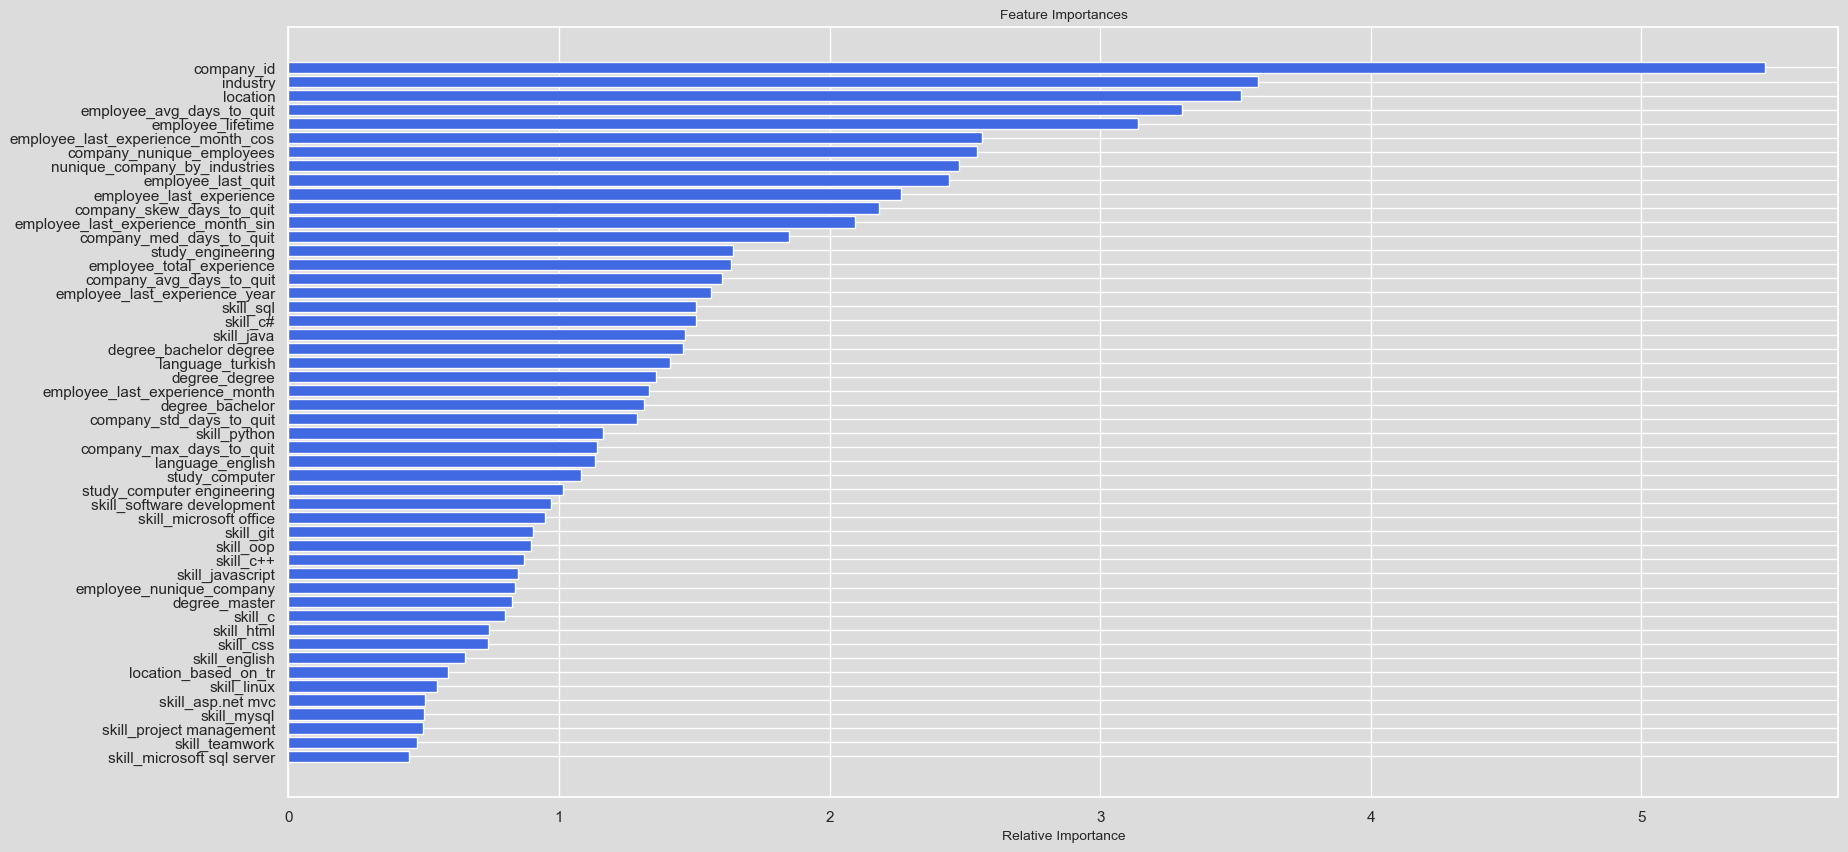

fold accuracy: 0.797329410433405
-----------------------------------| Fold 3 |-----------------------------------
train: (44182, 271)
val: (8837, 271)
Learning rate set to 0.044197
0:	learn: 0.6576434	test: 0.6377730	best: 0.6377730 (0)	total: 229ms	remaining: 15m 17s
200:	learn: 0.8552804	test: 0.7534231	best: 0.7534231 (195)	total: 38.6s	remaining: 12m 9s
400:	learn: 0.9209180	test: 0.7729999	best: 0.7729999 (398)	total: 1m 17s	remaining: 11m 32s
600:	learn: 0.9523109	test: 0.7763947	best: 0.7782053 (590)	total: 1m 56s	remaining: 10m 56s
800:	learn: 0.9691730	test: 0.7787711	best: 0.7799027 (728)	total: 2m 35s	remaining: 10m 20s
1000:	learn: 0.9798787	test: 0.7818264	best: 0.7828449 (985)	total: 3m 14s	remaining: 9m 42s
1200:	learn: 0.9858766	test: 0.7826185	best: 0.7834107 (1133)	total: 3m 53s	remaining: 9m 3s
1400:	learn: 0.9899054	test: 0.7819396	best: 0.7840896 (1236)	total: 4m 32s	remaining: 8m 24s
1600:	learn: 0.9926667	test: 0.7837501	best: 0.7843159 (1586)	total: 5m 10s	remai

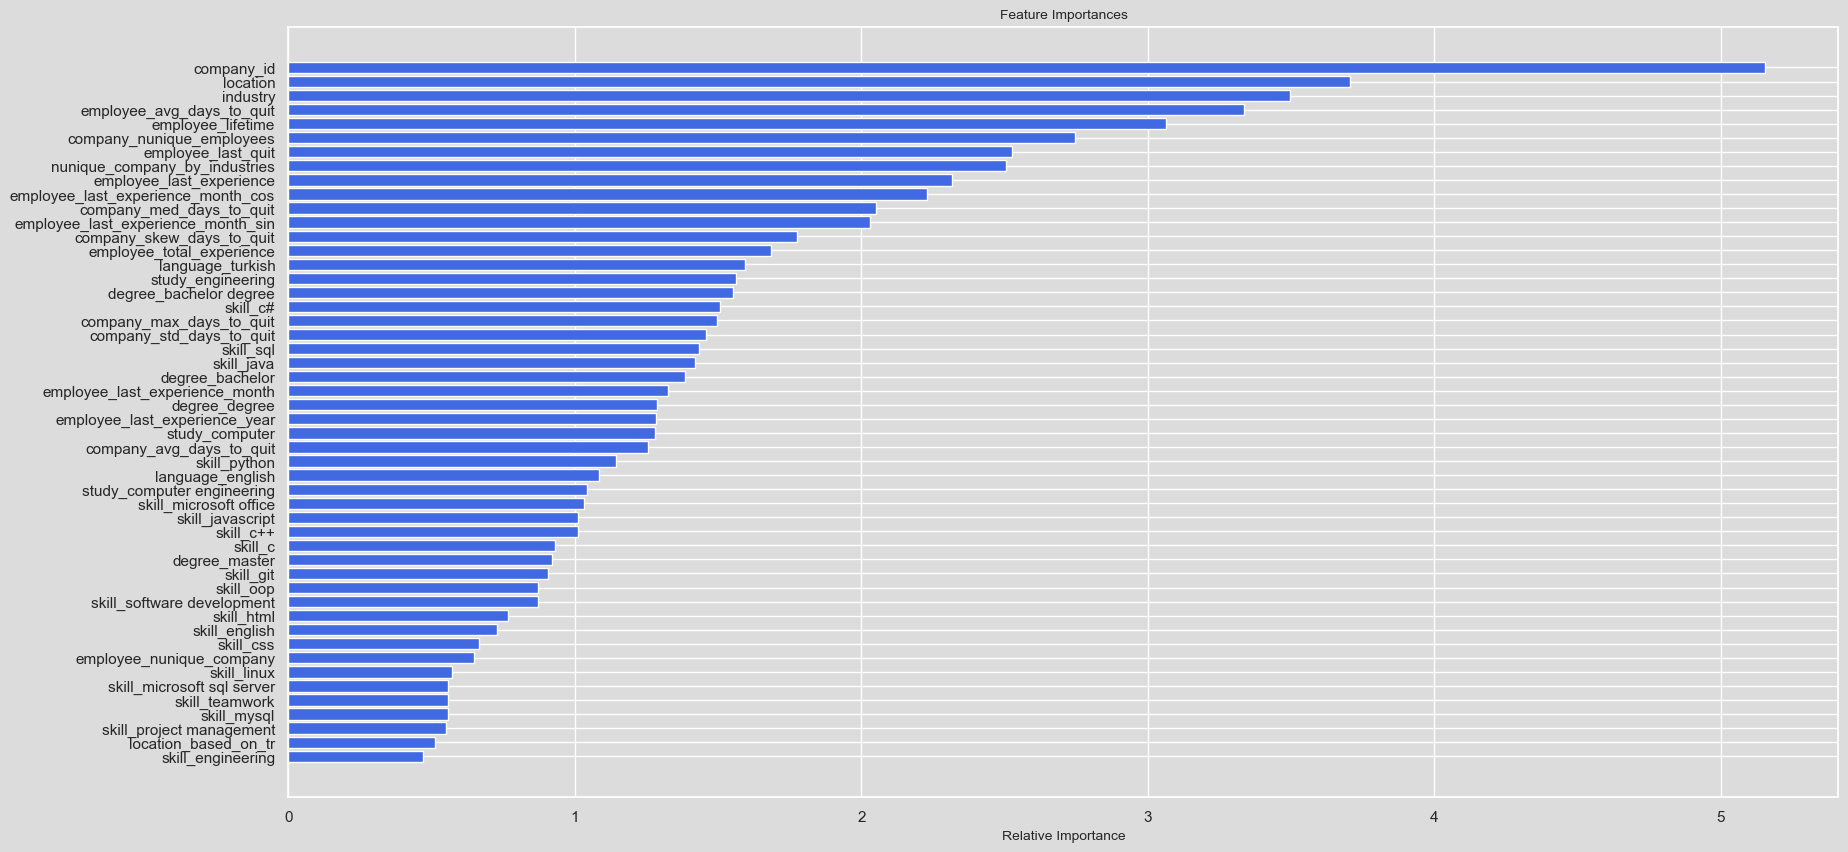

fold accuracy: 0.78556071064841
-----------------------------------| Fold 4 |-----------------------------------
train: (44183, 271)
val: (8836, 271)
Learning rate set to 0.044197
0:	learn: 0.6544146	test: 0.6319602	best: 0.6319602 (0)	total: 251ms	remaining: 16m 45s
200:	learn: 0.8520245	test: 0.7495473	best: 0.7500000 (199)	total: 37.7s	remaining: 11m 53s
400:	learn: 0.9154200	test: 0.7702580	best: 0.7702580 (399)	total: 1m 16s	remaining: 11m 25s
600:	learn: 0.9492791	test: 0.7816885	best: 0.7816885 (600)	total: 1m 55s	remaining: 10m 51s
800:	learn: 0.9672272	test: 0.7824808	best: 0.7847442 (768)	total: 2m 34s	remaining: 10m 15s
1000:	learn: 0.9778648	test: 0.7867813	best: 0.7880263 (921)	total: 3m 12s	remaining: 9m 37s
1200:	learn: 0.9849490	test: 0.7870077	best: 0.7894975 (1132)	total: 3m 53s	remaining: 9m 3s
1400:	learn: 0.9893851	test: 0.7862155	best: 0.7894975 (1132)	total: 4m 37s	remaining: 8m 33s
Stopped by overfitting detector  (400 iterations wait)

bestTest = 0.7894975102
b

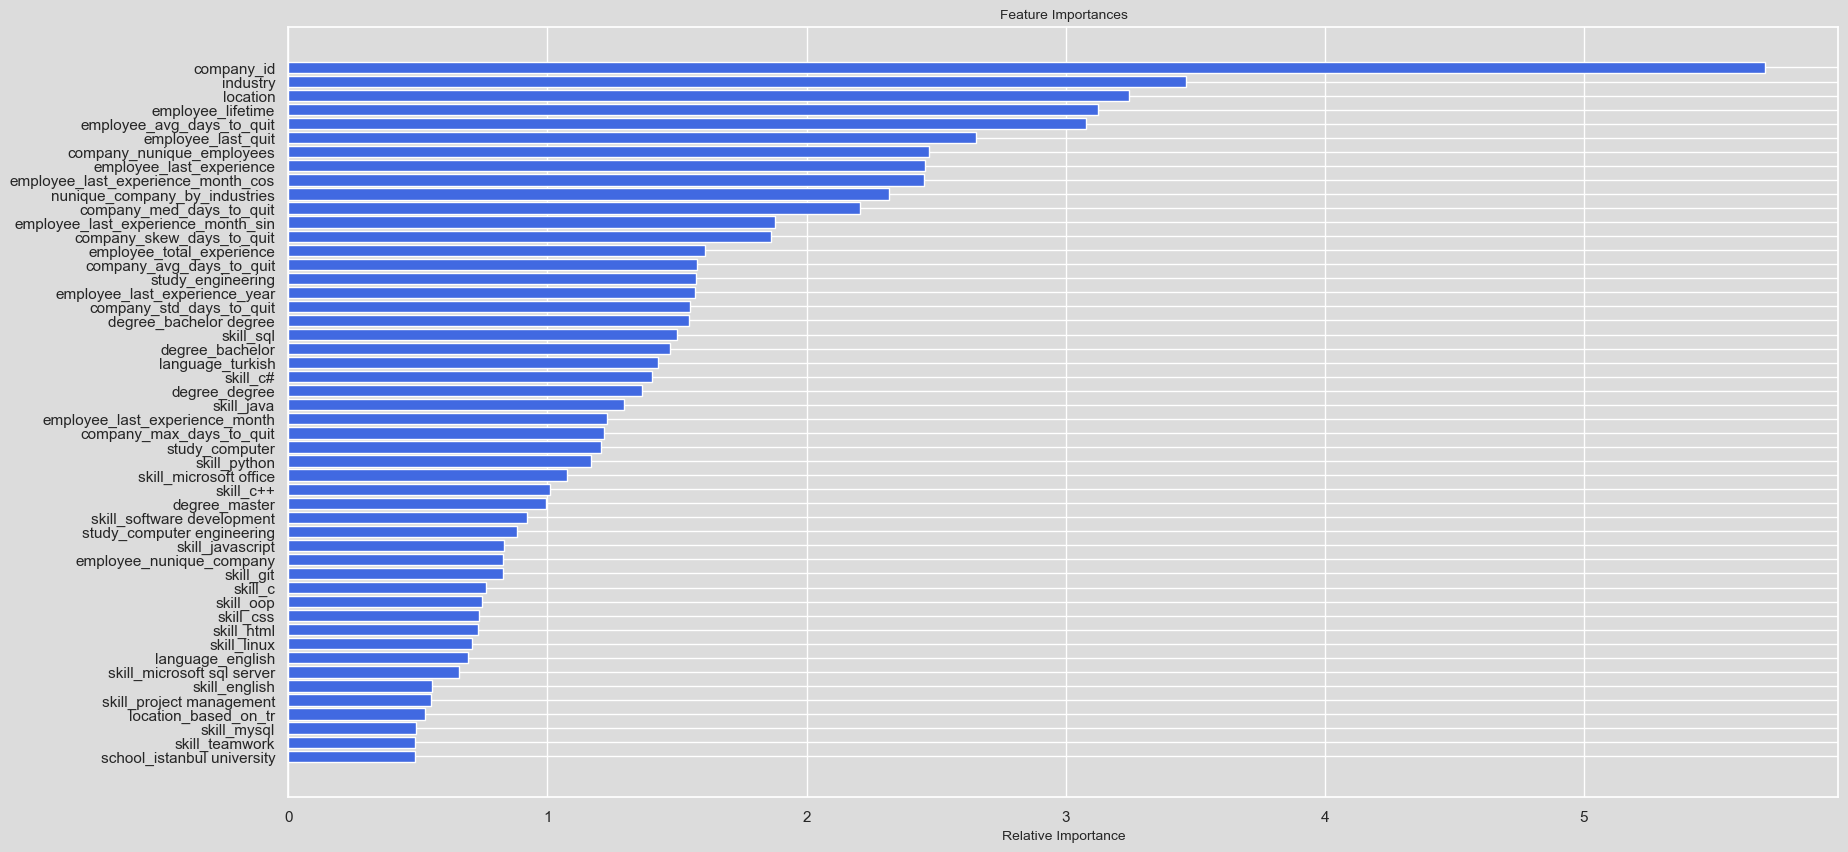

fold accuracy: 0.7894975101856043
-----------------------------------| Fold 5 |-----------------------------------
train: (44183, 271)
val: (8836, 271)
Learning rate set to 0.044197
0:	learn: 0.6524908	test: 0.6386374	best: 0.6386374 (0)	total: 275ms	remaining: 18m 19s
200:	learn: 0.8538805	test: 0.7589407	best: 0.7589407 (200)	total: 41.2s	remaining: 12m 58s
400:	learn: 0.9199919	test: 0.7727478	best: 0.7732005 (386)	total: 1m 22s	remaining: 12m 24s
600:	learn: 0.9511124	test: 0.7770484	best: 0.7782933 (551)	total: 2m 3s	remaining: 11m 40s
800:	learn: 0.9689700	test: 0.7780670	best: 0.7788592 (631)	total: 2m 44s	remaining: 10m 57s
1000:	learn: 0.9798112	test: 0.7796514	best: 0.7799909 (978)	total: 3m 25s	remaining: 10m 14s
1200:	learn: 0.9859675	test: 0.7813490	best: 0.7829335 (1174)	total: 4m 8s	remaining: 9m 38s
1400:	learn: 0.9899509	test: 0.7823676	best: 0.7829335 (1174)	total: 4m 48s	remaining: 8m 55s
1600:	learn: 0.9927121	test: 0.7834993	best: 0.7847442 (1500)	total: 5m 29s	rem

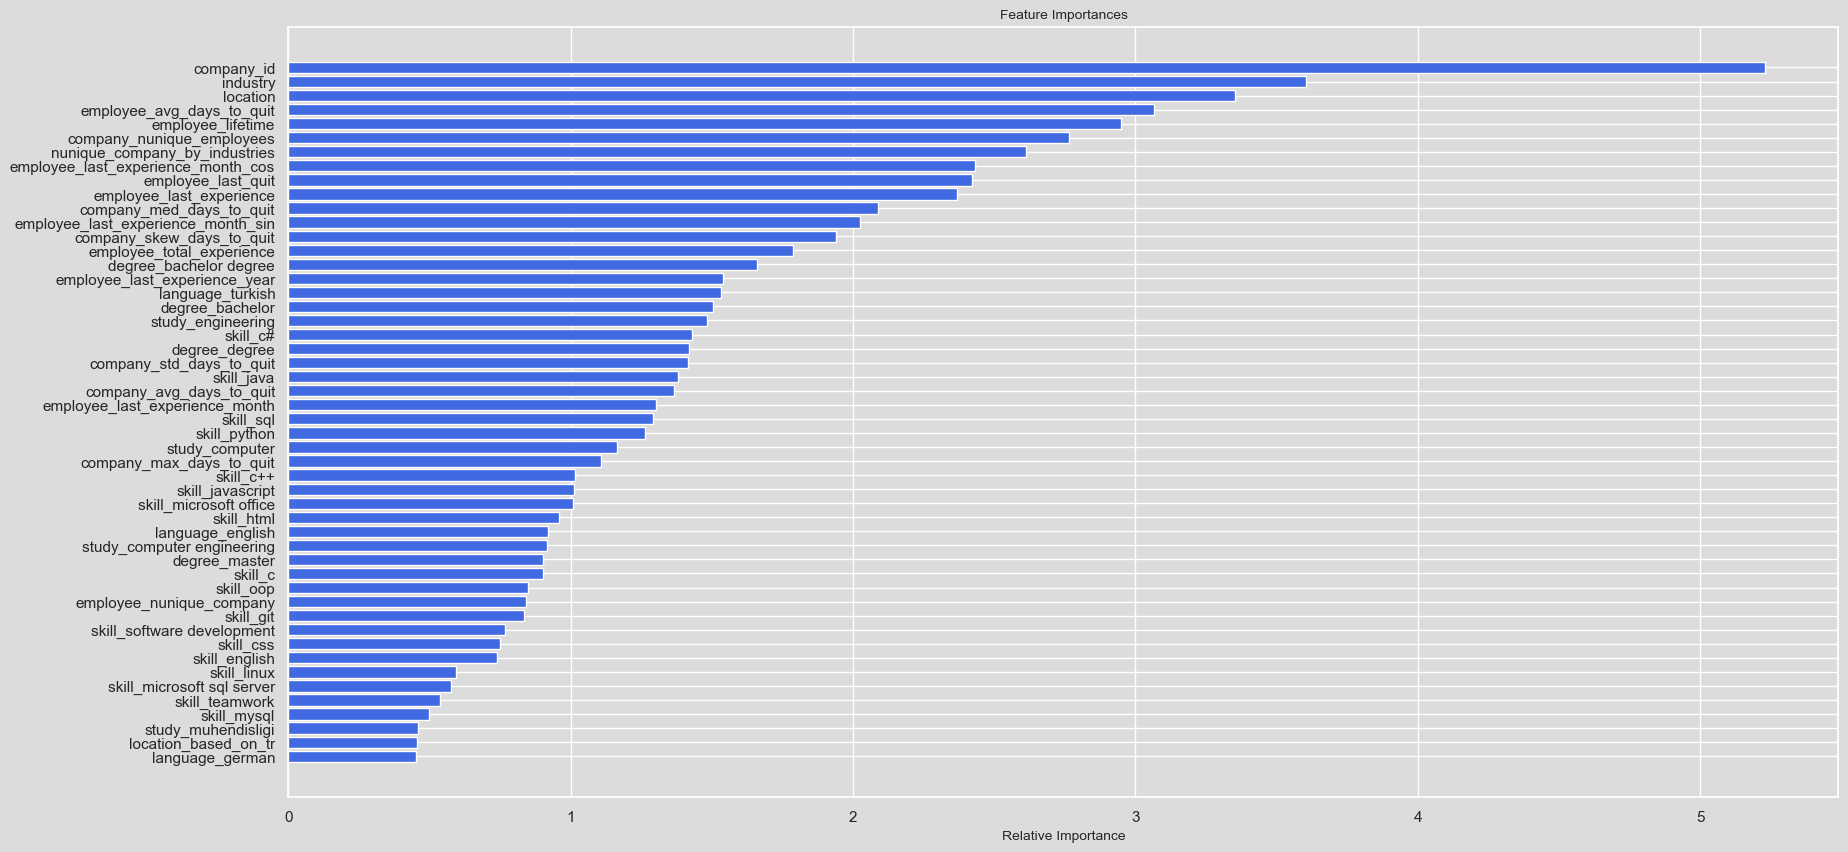

fold accuracy: 0.7847442281575373
-----------------------------------| Fold 6 |-----------------------------------
train: (44183, 271)
val: (8836, 271)
Learning rate set to 0.044197
0:	learn: 0.6515176	test: 0.6418062	best: 0.6418062 (0)	total: 268ms	remaining: 17m 51s
200:	learn: 0.8532015	test: 0.7573563	best: 0.7576958 (198)	total: 40s	remaining: 12m 36s
400:	learn: 0.9203766	test: 0.7715029	best: 0.7718425 (397)	total: 1m 18s	remaining: 11m 48s
600:	learn: 0.9523346	test: 0.7755772	best: 0.7769353 (586)	total: 1m 59s	remaining: 11m 13s
800:	learn: 0.9688115	test: 0.7788592	best: 0.7798778 (714)	total: 2m 38s	remaining: 10m 32s
1000:	learn: 0.9791322	test: 0.7812359	best: 0.7819149 (952)	total: 3m 18s	remaining: 9m 54s
1200:	learn: 0.9854922	test: 0.7846311	best: 0.7851969 (1097)	total: 3m 59s	remaining: 9m 17s
1400:	learn: 0.9899735	test: 0.7842915	best: 0.7859891 (1319)	total: 4m 38s	remaining: 8m 37s
1600:	learn: 0.9926216	test: 0.7853101	best: 0.7861023 (1524)	total: 5m 17s	rema

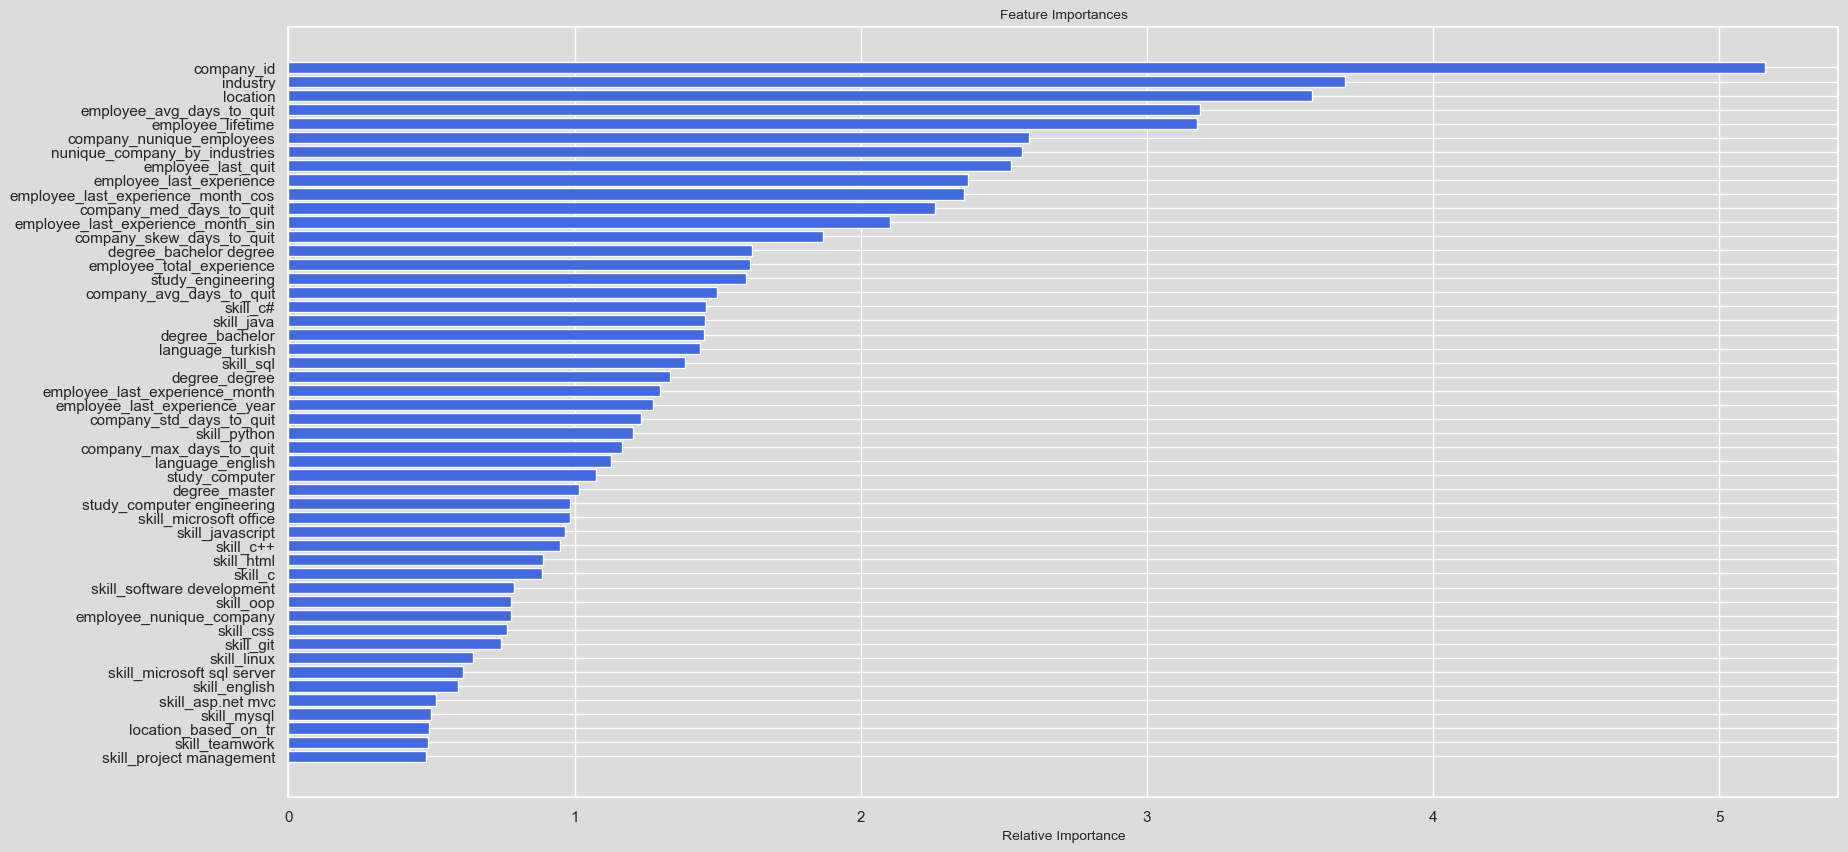

fold accuracy: 0.7871208691715709
accuracy: 0.7875855825270186
folds avg accuracy: 0.7875855562334033


In [9]:
#X = train_set.drop(columns=[target], axis=1)
#y = train_set[target]
#features = X.columns
#
#X_test = test_set.drop(columns=[target], axis=1)
#y_oof = np.zeros(X.shape[0])
#y_pred = np.zeros(X_test.shape[0])
#y_score = np.zeros((X_test.shape[0], 2))
#
#scores = list()
#for idx, (train_ind, val_ind) in enumerate(kf.split(X, y)):
#    print(f"| Fold {idx+1} |".center(80, "-"))
#    model = CatBoostClassifier(**params)
#    X_train = X.iloc[train_ind]
#    y_train = y.iloc[train_ind]
#    X_val = X.iloc[val_ind]
#    y_val = y.iloc[val_ind]
#    print(f'train: {X_train.shape}')
#    print(f'val: {X_val.shape}')
#
#    model.fit(
#        X_train,
#        y_train,
#        eval_set=[(X_val, y_val)],
#        early_stopping_rounds=400,
#        verbose=200,
#    )
#
#    plot_importances(model, features)
#
#    val_pred = model.predict(X_val)
#    y_oof[val_ind] += val_pred
#
#    test_pred = model.predict(X_test)
#    y_pred += test_pred / config.n_folds
#
#    test_score = model.predict_proba(X_test)
#    y_score += test_score / config.n_folds
#
#    print(f'fold accuracy: {accuracy_score(y_val, val_pred)}')
#    scores.append(accuracy_score(y_val, val_pred))
#    del X_train, y_train, X_val, y_val
#    gc.collect()
#
#val_score = accuracy_score(y, y_oof)
#print(f'accuracy: {val_score}')
#print(f'folds avg accuracy: {np.mean(scores)}')
#cat_scores = deepcopy(y_score)

accuracy: 0.787491276712122 <br>
folds avg accuracy: 0.7874912728300436 <br>

accuracy: 0.7857749108810049

-----------------------------------| Fold 1 |-----------------------------------
[0]	validation_0-logloss:0.69122
[200]	validation_0-logloss:0.56376
[400]	validation_0-logloss:0.53699
[600]	validation_0-logloss:0.51983
[800]	validation_0-logloss:0.50673
[1000]	validation_0-logloss:0.49587
[1200]	validation_0-logloss:0.48681
[1400]	validation_0-logloss:0.47886
[1600]	validation_0-logloss:0.47263
[1800]	validation_0-logloss:0.46791
[2000]	validation_0-logloss:0.46425
[2200]	validation_0-logloss:0.46143
[2400]	validation_0-logloss:0.45924
[2600]	validation_0-logloss:0.45784
[2800]	validation_0-logloss:0.45702
[3000]	validation_0-logloss:0.45643
[3200]	validation_0-logloss:0.45630
[3400]	validation_0-logloss:0.45688
[3538]	validation_0-logloss:0.45727


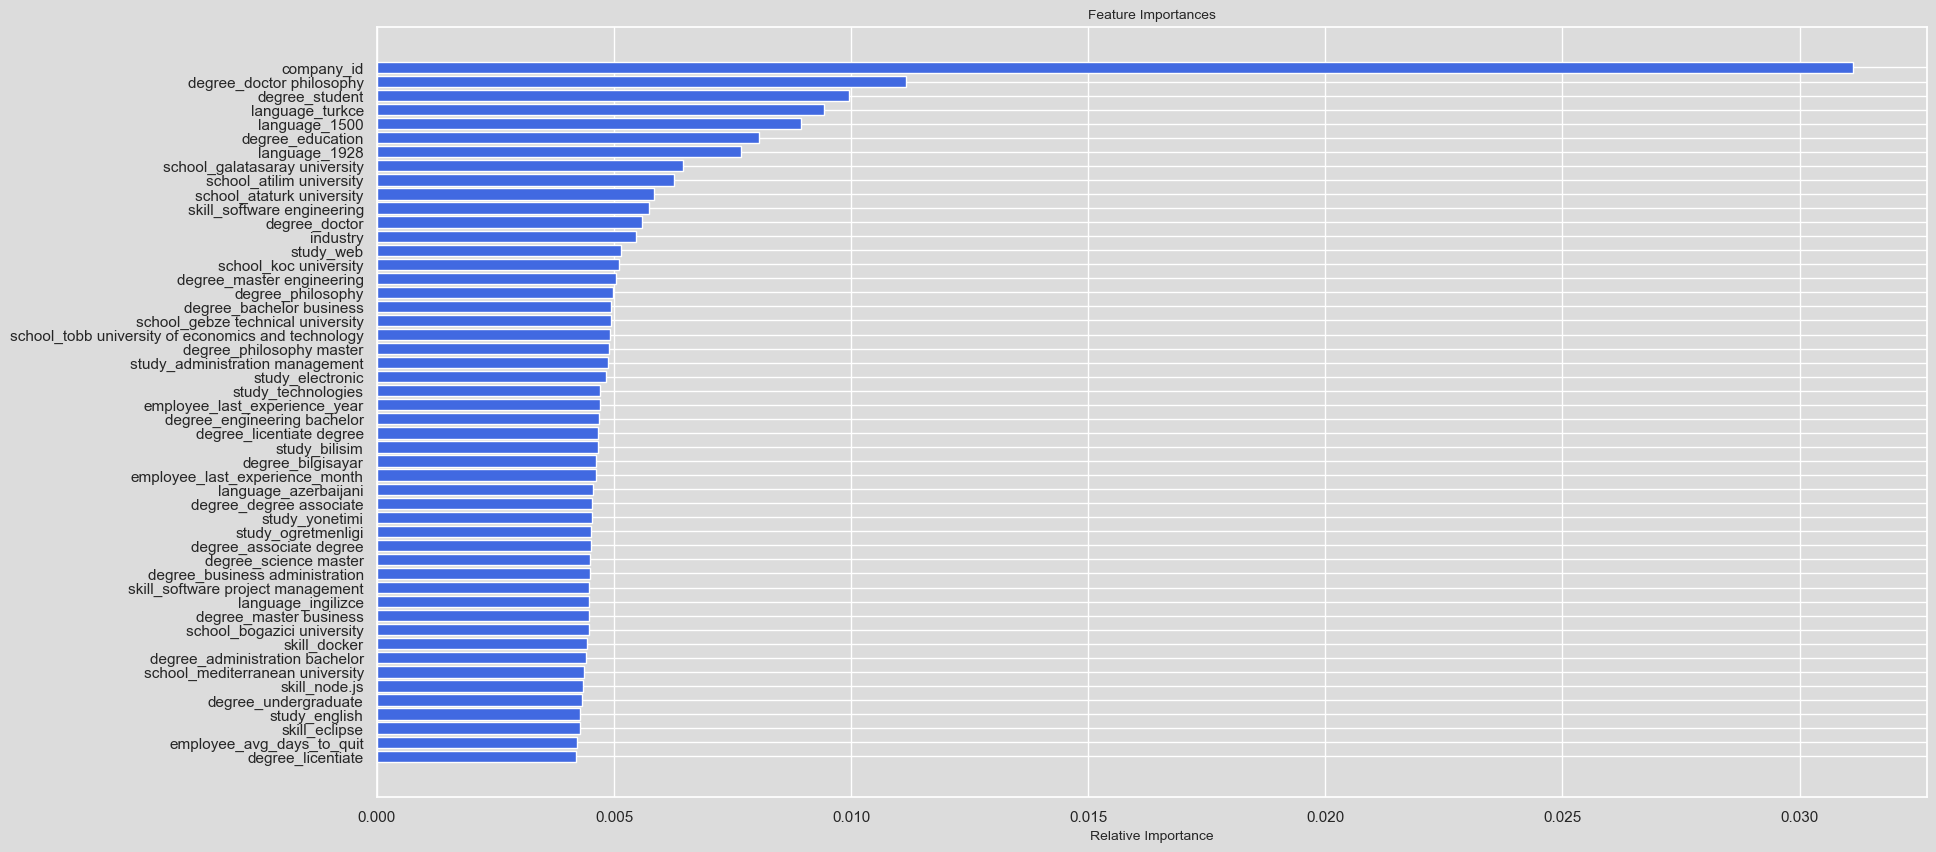

fold accuracy: 0.7809211270793256
-----------------------------------| Fold 2 |-----------------------------------
[0]	validation_0-logloss:0.69094
[200]	validation_0-logloss:0.54960
[400]	validation_0-logloss:0.51929
[600]	validation_0-logloss:0.50059
[800]	validation_0-logloss:0.48558
[1000]	validation_0-logloss:0.47342
[1200]	validation_0-logloss:0.46309
[1400]	validation_0-logloss:0.45480
[1600]	validation_0-logloss:0.44778
[1800]	validation_0-logloss:0.44211
[2000]	validation_0-logloss:0.43771
[2200]	validation_0-logloss:0.43433
[2400]	validation_0-logloss:0.43147
[2600]	validation_0-logloss:0.42988
[2800]	validation_0-logloss:0.42852
[3000]	validation_0-logloss:0.42791
[3200]	validation_0-logloss:0.42775
[3400]	validation_0-logloss:0.42770
[3600]	validation_0-logloss:0.42797
[3699]	validation_0-logloss:0.42820


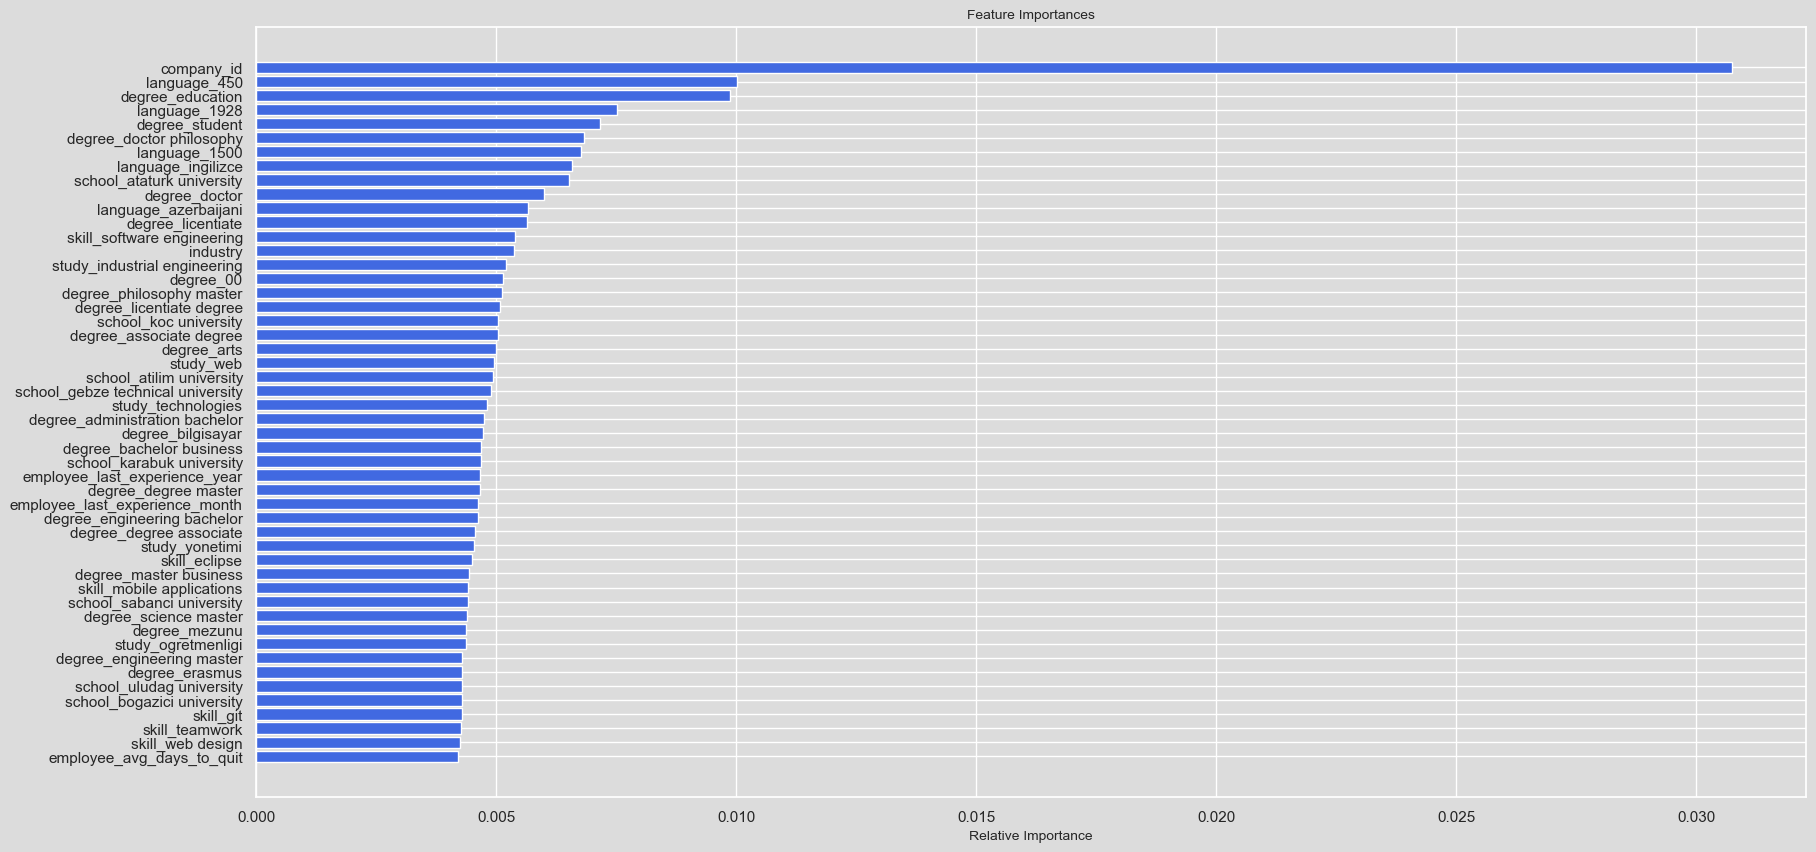

fold accuracy: 0.7950661989362906
-----------------------------------| Fold 3 |-----------------------------------
[0]	validation_0-logloss:0.69113
[200]	validation_0-logloss:0.55913
[400]	validation_0-logloss:0.53204
[600]	validation_0-logloss:0.51477
[800]	validation_0-logloss:0.50097
[1000]	validation_0-logloss:0.48951
[1200]	validation_0-logloss:0.47979
[1400]	validation_0-logloss:0.47204
[1600]	validation_0-logloss:0.46590
[1800]	validation_0-logloss:0.46083
[2000]	validation_0-logloss:0.45721


KeyboardInterrupt: 

In [10]:
#xgb_params = {'max_depth': 12,
#              'subsample': 0.8,
#              #'eta': 0.02,
#              #'reg_alpha': 2,
#              #'reg_lambda': 24,
#              #'max_cat_to_onehot': 150,
#              'learning_rate': 0.01
#              }
#
##xgb_params['eval_metric'] = 'accuracy'
#xgb_params['enable_categorical'] = True
#xgb_params['random_state'] = config.seed
#xgb_params['tree_method'] = 'hist'
#xgb_params['n_estimators'] = 5000
#
##kf = KFold(n_splits=config.n_folds)
#kf = KFold(n_splits=config.n_folds, shuffle =True, random_state=config.seed)
#
#X = train_set.drop(columns=[target], axis=1)
#y = train_set[target]
#features = X.columns
#
#X_test = test_set.drop(columns=[target], axis=1)
#y_oof = np.zeros(X.shape[0])
#y_pred = np.zeros(X_test.shape[0])
#y_score = np.zeros((X_test.shape[0], 2))
#
#scores = list()
#for idx, (train_ind, val_ind) in enumerate(kf.split(X, y)):
#    print(f"| Fold {idx+1} |".center(80, "-"))
#    model = XGBClassifier(**xgb_params)
#    X_train = X.iloc[train_ind]
#    y_train = y.iloc[train_ind]
#    X_val = X.iloc[val_ind]
#    y_val = y.iloc[val_ind]
#
#    model.fit(
#        X_train,
#        y_train,
#        eval_set=[(X_val, y_val)],
#        early_stopping_rounds = 400,
#        verbose = 200
#    )
#
#    plot_importances(model, features)
#
#    val_pred = model.predict(X_val)
#    y_oof[val_ind] += val_pred
#
#    test_pred = model.predict(X_test)
#    y_pred += test_pred / config.n_folds
#
#    test_score = model.predict_proba(X_test)
#    y_score += test_score / config.n_folds
#
#    print(f'fold accuracy: {accuracy_score(y_val, val_pred)}')
#    scores.append(accuracy_score(y_val, val_pred))
#    del X_train, y_train, X_val, y_val
#    gc.collect()
#
#val_score = accuracy_score(y, y_oof)
#print(f'accuracy: {val_score}')
#print(f'folds avg accuracy: {np.mean(scores)}')
#xgb_scores = deepcopy(y_score)

fold accuracy: 0.7875735626980535 <br>
accuracy: 0.7855674380882325 <br>
folds avg accuracy: 0.7855673765695522 <br>

In [29]:
#sub[target] = np.where((cat_scores[:, 1] * 0.45) + (xgb_scores[:, 1] * 0.55) >= 0.5, 1, 0)
#
#sub.head()

user_id  moved_after_2019
0    17449                 0
1    33967                 0
2     2110                 0
3    55082                 0
4    37165                 0

In [30]:
#sub[target].value_counts()

0    9030
1    4225
Name: moved_after_2019, dtype: int64

Class: 0 =    9047 <br>
Class: 1 =    4208 <br>

In [18]:
#sub.to_csv(f'../submissions/submission_ensemble_cat_xgb_v13.csv', index = False)

In [20]:
#sub[target].value_counts()

0    9026
1    4229
Name: moved_after_2019, dtype: int64

In [21]:
#target = 'moved_after_2019'
#sub1 = pd.read_csv('../submissions/ensemble_cat_xgb_v5.csv')
#sub2 = pd.read_csv('../submissions/ensemble_cat_xgb_v6.csv')
#sub3 = pd.read_csv('../submissions/ensemble_cat_xgb_v7.csv')
#sub4 = pd.read_csv('../submissions/ensemble_cat_xgb_v9.csv')

#sub[target] = np.where((sub1[target] * 0.35) + (sub2[target] * 0.35) + (sub3[target] * 0.15) + (sub4[target] * 0.15) >= 0.5, 1, 0)

#sub.to_csv(f'../submissions/ensemble_of_all_subs.csv', index = False)